# Library Imports

In [1]:
### Data handling libraries
import pandas as pd
import numpy as np

### data visualisation libraries
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


### scaling
from sklearn.preprocessing import StandardScaler, RobustScaler


### feature engineering libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype



### modelling libraries
from sklearn.linear_model import LogisticRegression



### model tuning, cross validation
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold


### performance metric libraries
from sklearn.metrics import (
    roc_curve, auc, classification_report, accuracy_score, confusion_matrix,
    roc_auc_score
  )



# Useful Utility functions

In [2]:
def find_missing_perc(df, columns_missing_values):
  missing_perc_df_list = []
  for c in columns_missing_values:
    missing_perc_df_list.append(pd.DataFrame(df[c].isna().value_counts(normalize=True) * 100)
    .reset_index().rename(columns={c: c+ ' %', 'index':'is_missing'}))
    missing_perc_df_list.append(pd.DataFrame(df[c].isna().value_counts())
    .reset_index().rename(columns={c: c+ ' Count', 'index':'is_missing'}))
  missing_perc_df = pd.concat(missing_perc_df_list, axis=1)
  missing_perc_df = missing_perc_df.loc[:,~missing_perc_df.columns.duplicated()].T
  return missing_perc_df


def find_possible_cat_cont_cols(df, unique_count_thresh=10) : 
  cont_cols = df.columns[df.nunique() > unique_count_thresh].tolist()
  cat_cols = df.columns[df.nunique() <= unique_count_thresh].tolist()
  return cat_cols, cont_cols


def IQR_method(series):
  q1, median, q3 = np.percentile(series, [25, 50, 75])
  iqr = q3 - q1
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)

  return pd.Series((series < lower_bound) | (series > upper_bound)) 


def Z_method(series, std_threshold=3): 
  mean = np.mean(series)
  std = np.std(series)
  return pd.Series(((series - mean)/ std ) > std_threshold)


def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def train_categories(df):
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()


def apply_categories(df, trn):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories,
                                   ordered=True)


find_na_cols = lambda data: data.columns[data.isna().any()].tolist()

In [3]:
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc
def plot_auc_plots(model_output_dict, pos_label=1):
  markers = list(Line2D.markers.keys())
  plt.figure(figsize=(5, 5), dpi=100)
  for i, model_name in enumerate(model_output_dict.keys()):
    model_results = model_output_dict[model_name]

    fpr, tpr, threshold = roc_curve(model_results['y'],
                                    model_results['y_pred'],
                                    pos_label=pos_label)
    auc_score = auc(fpr, tpr)

    model_results['fpr'] = fpr
    model_results['tpr'] = tpr
    model_results['auc_score'] = auc_score


    plt.plot(fpr, tpr, marker=markers[i],
              label=f'{model_name} (auc = %0.3f)' % auc_score)

  plt.xlabel('False Positive Rate -->')
  plt.ylabel('True Positive Rate -->')
  plt.legend()
  plt.show()

# Loading the Data 

In [4]:
''' Useful options for csv files 
      1. parse_dates
      2. dayfirst (False by default)
      3. Headers 
      4. usecols : To read selected features from the csv file.
      5. engine : C, pyarrow or python ; pyarrow or C for faster reading
      6. on_bad_lines: {‘error’, ‘warn’, ‘skip’} or callable, default ‘error’
      7. index_col : Just in case if you need ti 
'''
train_data_filename = 'training_set.csv'
test_data_filename = 'test_set.csv'

train_data = pd.read_csv(train_data_filename, index_col=[0])
test_data = pd.read_csv(test_data_filename, index_col=[0])

# 
raw_data_dict = {
    'train' : train_data,
    'test' : test_data
}

In [5]:
train_data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X49,X50,X51,X52,X53,X54,X55,X56,X57,Y
0,0.00,0.00,4.34,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,1.342,0.000,0.000,1.200,2,12,0
1,0.00,0.56,0.56,0.00,1.12,0.56,2.25,0.00,0.00,0.56,...,0.0,0.083,0.0,0.503,0.000,0.083,16.304,148,375,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.000,0.000,0.000,1.000,1,5,0
3,0.64,0.00,0.64,0.00,1.93,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.462,0.370,0.000,2.440,22,122,1
4,0.58,0.00,0.00,35.46,0.58,0.00,0.58,0.58,0.00,0.00,...,0.0,0.000,0.0,0.239,0.239,0.000,3.338,123,207,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.000,0.000,0.000,1.714,4,12,0
3906,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.0,0.000,0.000,0.000,2.000,3,4,0
3907,0.12,0.00,0.12,0.00,0.00,0.25,0.00,0.00,0.00,0.00,...,0.0,0.093,0.0,0.023,0.000,0.000,1.247,5,131,0
3908,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.12,0.00,0.00,...,0.0,0.198,0.0,0.198,0.198,0.000,3.857,25,81,1


# Exploratory Data Analysis

## Understaing the Data

In [99]:
train_data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X49,X50,X51,X52,X53,X54,X55,X56,X57,Y
count,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,...,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000,3910.000000
mean,0.102990,0.206419,0.284419,0.062074,0.311309,0.095974,0.112320,0.106041,0.091146,0.244345,...,0.037493,0.139252,0.015876,0.272971,0.077820,0.043828,5.047150,52.338107,283.059079,0.392327
std,0.296322,1.253828,0.504352,1.369361,0.656195,0.261455,0.389516,0.398694,0.271417,0.667065,...,0.235054,0.276309,0.083600,0.858634,0.256991,0.452862,31.397035,204.445218,578.339858,0.488331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.580750,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.066000,0.000000,0.000000,0.000000,0.000000,2.263500,15.000000,94.000000,0.000000
75%,0.000000,0.000000,0.430000,0.000000,0.387500,0.000000,0.000000,0.000000,0.000000,0.170000,...,0.000000,0.188000,0.000000,0.317250,0.054000,0.000000,3.714000,43.000000,264.000000,1.000000
max,4.340000,14.280000,4.540000,42.810000,9.090000,3.570000,7.270000,11.110000,3.230000,18.180000,...,4.385000,9.752000,2.777000,32.478000,6.003000,19.829000,1102.500000,9989.000000,10062.000000,1.000000


In [100]:
train_data.info(memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3910 entries, 0 to 3909
Data columns (total 58 columns):
X1     3910 non-null float64
X2     3910 non-null float64
X3     3910 non-null float64
X4     3910 non-null float64
X5     3910 non-null float64
X6     3910 non-null float64
X7     3910 non-null float64
X8     3910 non-null float64
X9     3910 non-null float64
X10    3910 non-null float64
X11    3910 non-null float64
X12    3910 non-null float64
X13    3910 non-null float64
X14    3910 non-null float64
X15    3910 non-null float64
X16    3910 non-null float64
X17    3910 non-null float64
X18    3910 non-null float64
X19    3910 non-null float64
X20    3910 non-null float64
X21    3910 non-null float64
X22    3910 non-null float64
X23    3910 non-null float64
X24    3910 non-null float64
X25    3910 non-null float64
X26    3910 non-null float64
X27    3910 non-null float64
X28    3910 non-null float64
X29    3910 non-null float64
X30    3910 non-null float64
X31    3910 non-null fl

In [101]:
target_variable = 'Y'

In [102]:
train_data.nunique()

X1      136
X2      160
X3      207
X4       37
X5      241
X6      138
X7      162
X8      161
X9      138
X10     235
X11     111
X12     306
X13     149
X14     124
X15     109
X16     242
X17     189
X18     220
X19     561
X20     138
X21     393
X22      80
X23     158
X24     138
X25     379
X26     264
X27     229
X28     183
X29     149
X30     172
X31     121
X32      98
X33     164
X34     101
X35     171
X36     152
X37     178
X38      51
X39     158
X40     120
X41      92
X42     174
X43     128
X44     147
X45     228
X46     210
X47      37
X48     100
X49     294
X50     608
X51     216
X52     894
X53     478
X54     281
X55    1950
X56     256
X57     852
Y         2
dtype: int64

In [103]:
# cols_to_drop = ['id']
# df_for_analysis = data_all.drop(cols_to_drop, axis=1)

In [104]:
# ?find_possible_cat_cont_cols

In [105]:
# ??find_possible_cat_cont_cols

In [106]:
poss_cat_cols, poss_cont_cols = find_possible_cat_cont_cols(train_data, unique_count_thresh=30)
len(poss_cat_cols), len(poss_cont_cols)

(1, 57)

From the above it is clear that almost all the data are continous variables.

### Finding the missing data for each features

In [107]:
train_data.isna().sum().sum()

0

In [108]:
### There are no missing values

In [109]:
# sns.heatmap(train_data.isna(), yticklabels=False, cbar=False, cmap='viridis')
# plt.show()

In [110]:
## features where there are null values present
# dqi_cols = find_na_cols(train_data)
# print(len(dqi_cols))
# find_missing_perc(train_data, dqi_cols)

#### Trying find type of missing Data
Missing data can be categorized three types. 
1. MCAR - Missing completely at Random
No relationship with Other variables
2. MAR - Missing at Random
There is some relation between other variables (some pattern observed)
3. MNAR - Missing Not at Random 
There is some pattern observed within the same variable

Dropping MCAR type data wouldn't affect the performance as they are missing randomly.

Dropping MAR or MNAR may introduce bias in the data. Dropping missing values is generally not recommended in such cases. 

But again it depends on different scenarios like amount of data and quality of data.

But in this case there are no missing data. No need to handle this case.

### Finding Outliers in the data

In [111]:
# rename_column_dict = {
#     c: c + ' IQR Outler' for c in poss_cont_cols
# }
iqr_outlier_df = train_data[poss_cont_cols].apply(IQR_method) #.rename(columns=rename_column_dict)
outlier_cols = list(iqr_outlier_df.sum().sort_values(ascending=False).to_dict().keys())

In [112]:
z_outlier_df = train_data[poss_cont_cols].apply(Z_method)
# z_outlier_df.sum()

2978


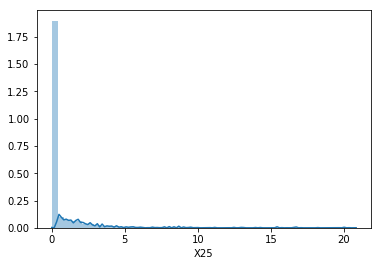

3017


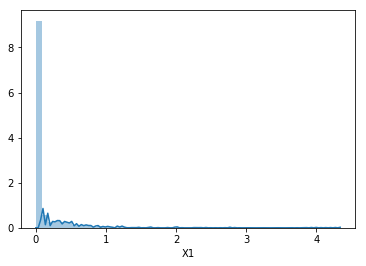

3026


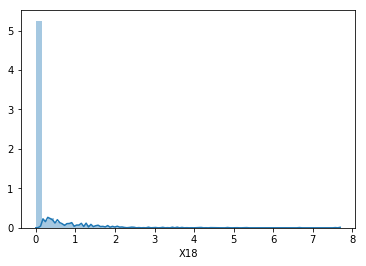

3050


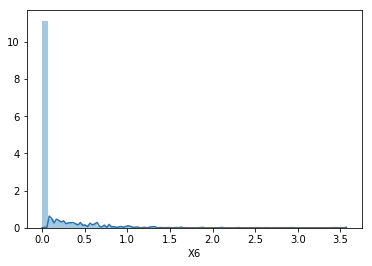

2794


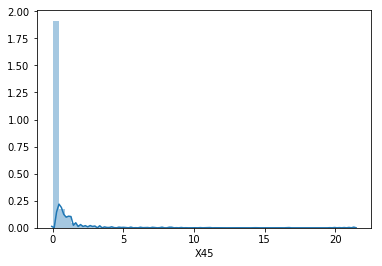

3821


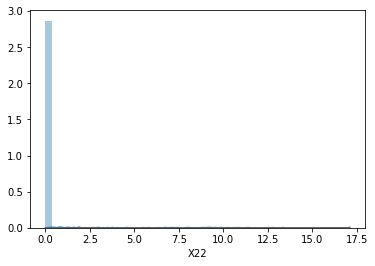

3836


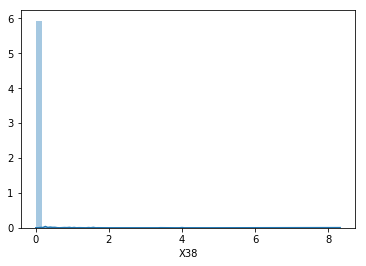

1152


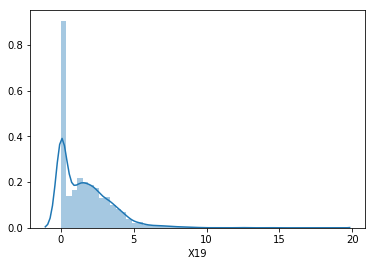

3854


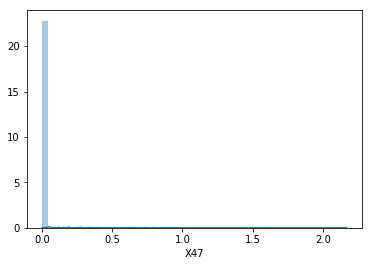

3871


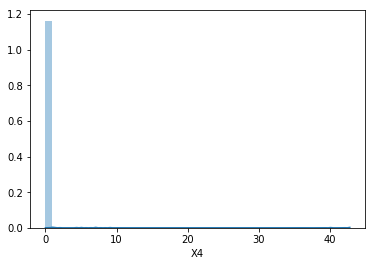

In [113]:
for col in outlier_cols[:5]: 
  print((train_data[col]==0).sum())
  sns.distplot(train_data[col])
  plt.show()
  # sns.distp/lot(np.log1p(train_data[col]))
  # plt.show()

for col in outlier_cols[-5:]: 
  print((train_data[col]==0).sum())
  sns.distplot(train_data[col])
  plt.show()
  # sns.distplot(np.log1p(train_data[col]))
  # plt.show()

From distplot it is clear that there are lot of zeros in the most of the columns. 


In [119]:
cols_with_lots_zeros = train_data.columns[(train_data.values==0).any(axis=0)]
len(cols_with_lots_zeros)
# sns.heatmap(train_data[cols_with_no_zeros].corr(), annot=True)

55

In [120]:
train_data[cols_with_lots_zeros[1]].value_counts()

0.00     3146
14.28      28
0.10       23
0.08       22
0.19       21
         ... 
0.74        1
3.52        1
1.22        1
0.61        1
1.38        1
Name: X2, Length: 160, dtype: int64

There are lots of column having zeros. 

After analysing with the target variables we can drop few of the columns if there is no strong relation between them. 

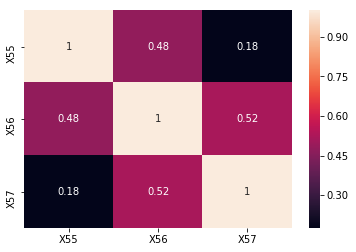

In [121]:
cols_with_no_zeros = train_data.columns[~(train_data.values==0).any(axis=0)]
sns.heatmap(train_data[cols_with_no_zeros].corr(), annot=True)

In [122]:
### They are not strongly correlated. 

In [123]:
cols_with_90_perc_zeros = train_data.columns[(train_data.values==0).sum(axis=0) / train_data.shape[0] > .90]

In [124]:
# sns.distplot(train_data[poss_cont_cols].sum(axis=1))
# plt.show()

In [128]:
# sns.distplot(train_data[cols_with_60_perc_zeros].sum(axis=1))
# plt.show()

In [126]:
cols_with_lots_zeros

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51',
       'X52', 'X53', 'X54', 'Y'],
      dtype='object')

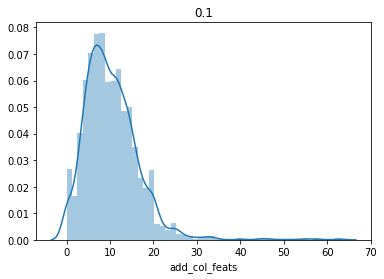

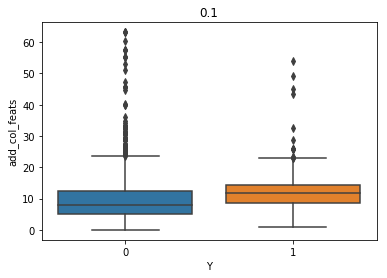

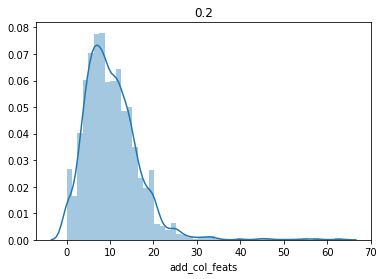

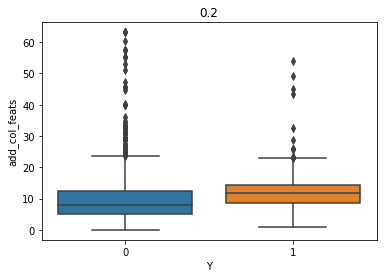

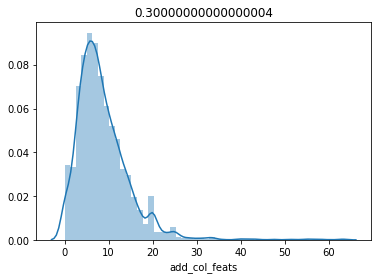

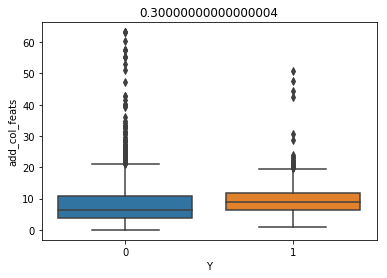

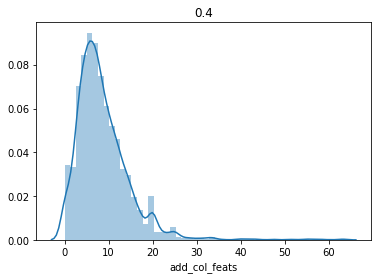

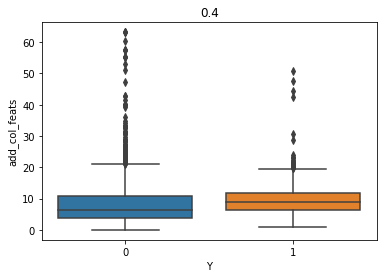

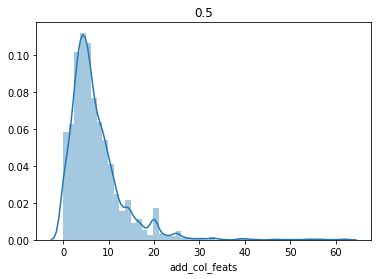

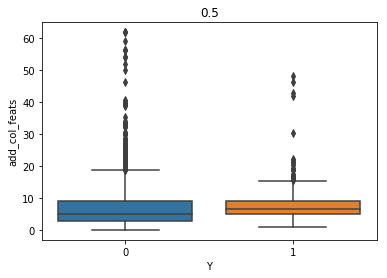

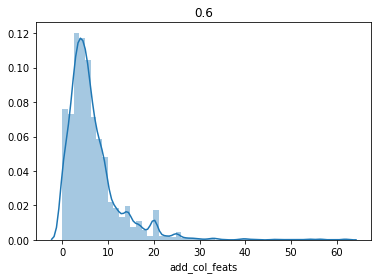

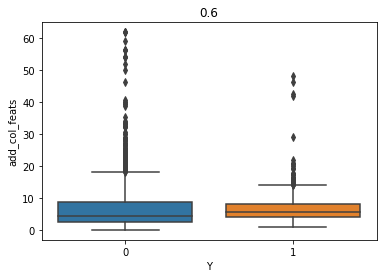

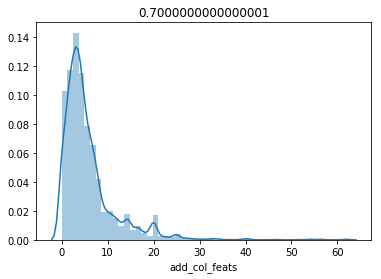

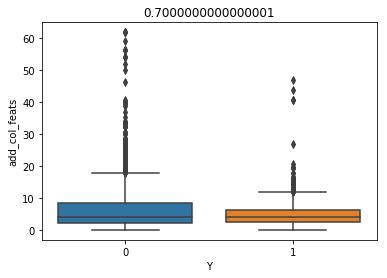

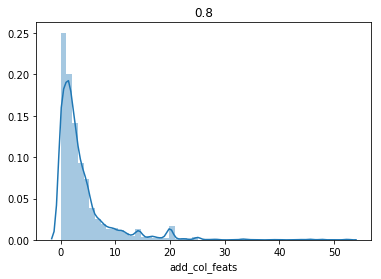

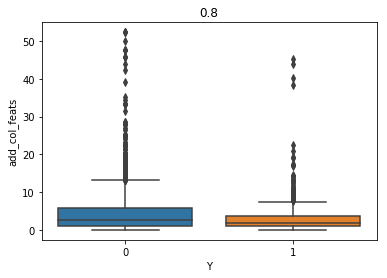

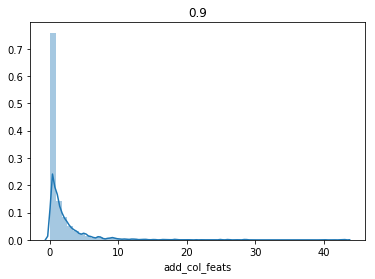

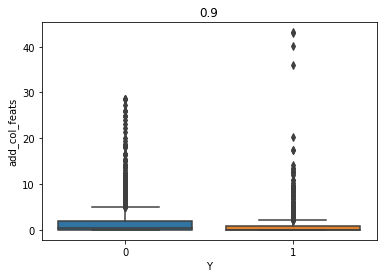

In [127]:
temp_data = train_data.copy()
for threshold in np.arange(.1, 1, .1):
  cols_with_ = train_data.columns[(train_data.values==0).sum(axis=0) / train_data.shape[0] > threshold]
  temp_data['add_col_feats'] = temp_data[cols_with_].sum(axis=1)
  sns.distplot(temp_data['add_col_feats']).set_title(f'{threshold}')
  plt.show()
  sns.boxplot(x=target_variable, y='add_col_feats', data=temp_data).set_title(f'{threshold}')
  plt.show()

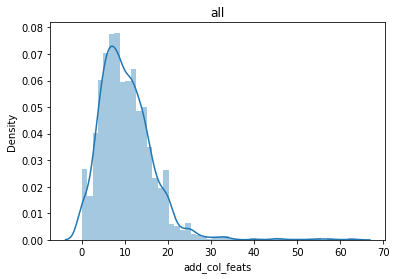

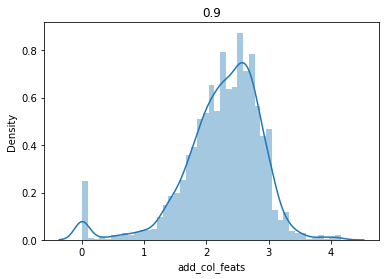

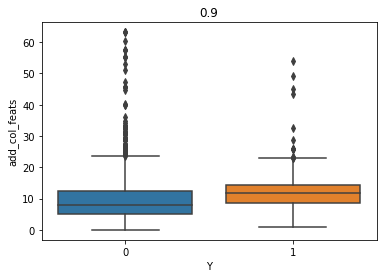

In [ ]:

temp_data['add_col_feats'] = temp_data[cols_with_lots_zeros].sum(axis=1)
sns.distplot(temp_data['add_col_feats']).set_title(f'all')
plt.show()
sns.distplot(np.log1p(temp_data['add_col_feats'])).set_title(f'{threshold}')
plt.show()
sns.boxplot(x=target_variable, y='add_col_feats', data=temp_data).set_title(f'{threshold}')
plt.show()

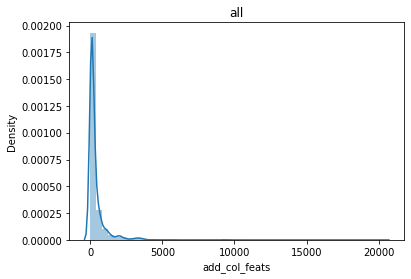

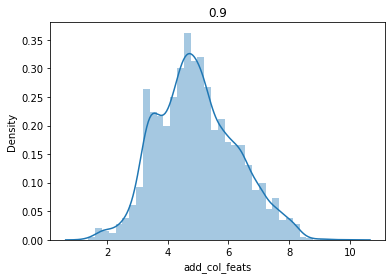

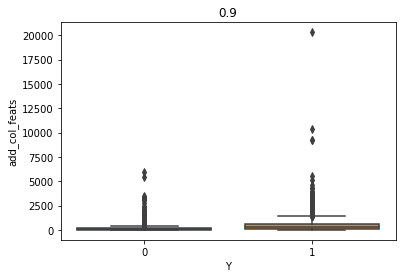

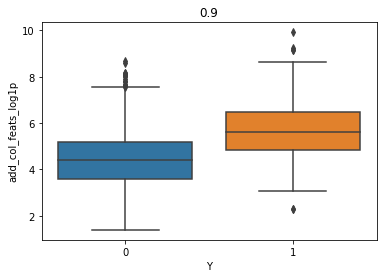

In [ ]:
temp_data['add_col_feats'] = temp_data[poss_cont_cols].sum(axis=1)
sns.distplot(temp_data['add_col_feats']).set_title(f'all')
plt.show()
sns.distplot(np.log1p(temp_data['add_col_feats'])).set_title(f'{threshold}')
plt.show()
sns.boxplot(x=target_variable, y='add_col_feats', data=temp_data).set_title(f'{threshold}')
plt.show()
temp_data['add_col_feats_log1p'] = np.log1p(temp_data['add_col_feats'])
sns.boxplot(x=target_variable, y='add_col_feats_log1p', data=temp_data).set_title(f'{threshold}')
plt.show()

Looks like the first 54 columns were transformed from a single column. 


In [95]:
# sns.relplot(x='add_col_feats_log1p', y='add_col_feats', hue=target_variable, data=temp_data)

In [ ]:
lr = LogisticRegression()

In [ ]:
# sns.lineplot(temp_data['add_col_feats'])

In [ ]:
# for col in cols_with_no_zeros:
#   sns.distplot(temp_data[col]).set_title(f'{threshold}')
#   plt.show()
#   sns.boxplot(x=target_variable, y=col, data=temp_data).set_title(f'{threshold}')
#   plt.show()

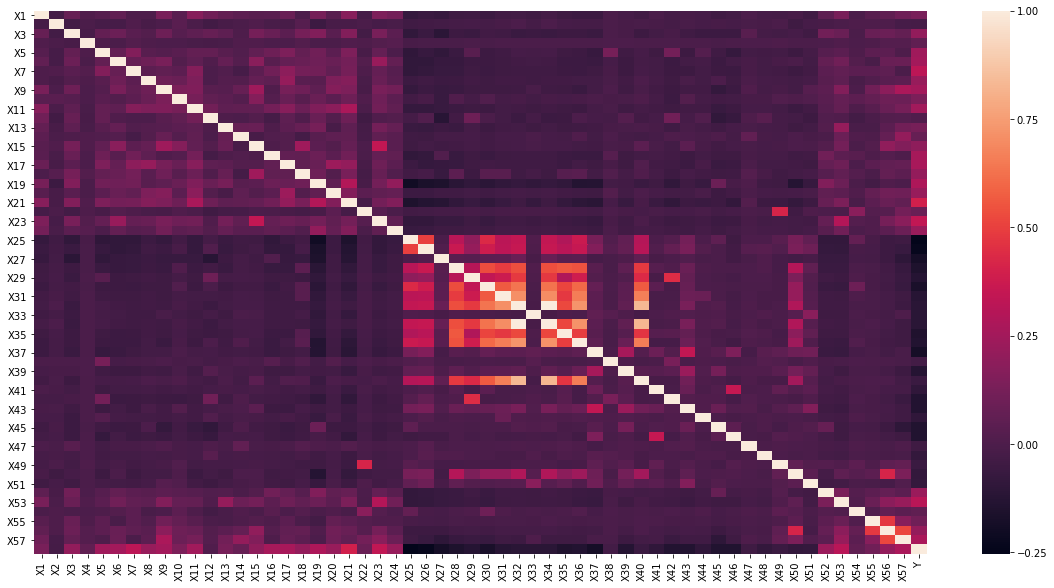

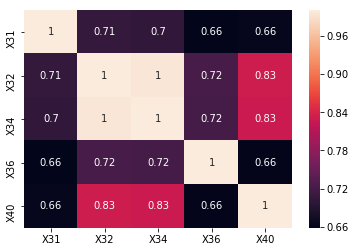

In [129]:
corr_df = pd.DataFrame(train_data.corr())
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr_df)
plt.show()
corr_df_unstacked = corr_df.unstack().reset_index()
highly_correlated = corr_df_unstacked[(corr_df_unstacked['level_0'] != corr_df_unstacked['level_1']) &
                  (abs(corr_df_unstacked[0]) > .65)]
t = highly_correlated.level_0.unique()
sns.heatmap(train_data[t].corr(), annot=True)

This indicates there are few features which are highly correlated and there is scope for dimensionality reduction. We can use PCA as a preprocessing step. 

In [ ]:
# iqr_outlier_df.sum()

In [ ]:
### Univariate Analysis

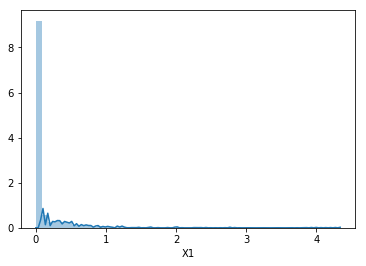

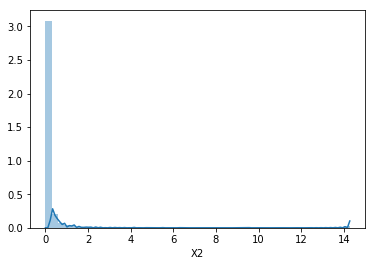

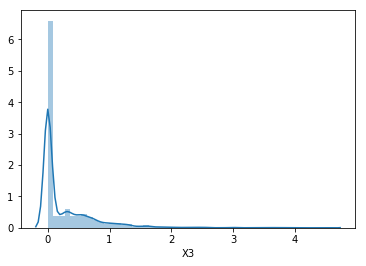

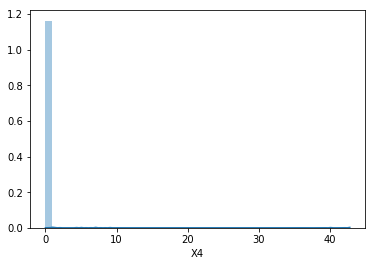

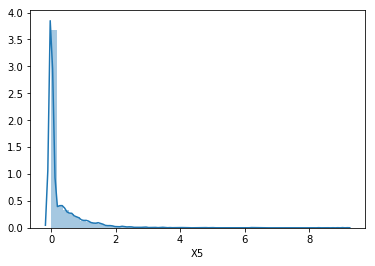

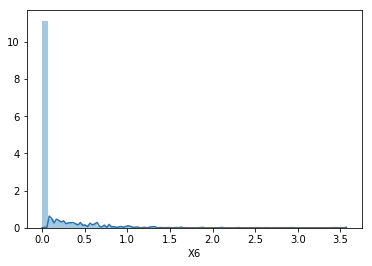

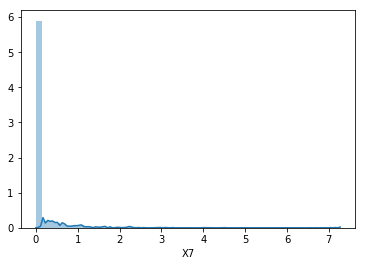

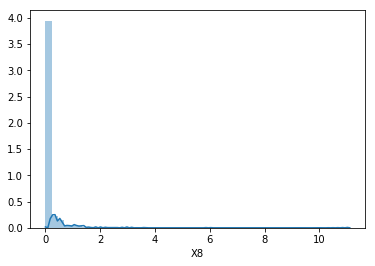

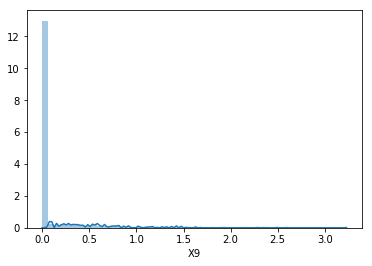

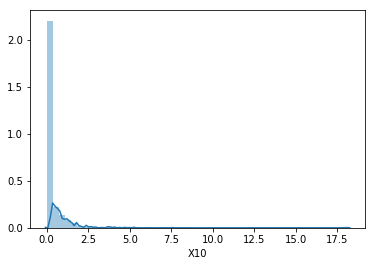

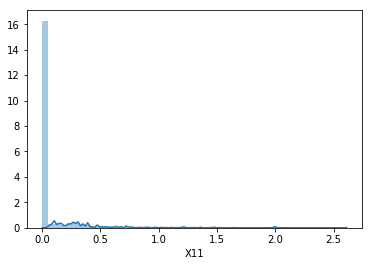

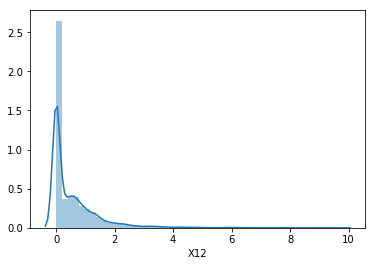

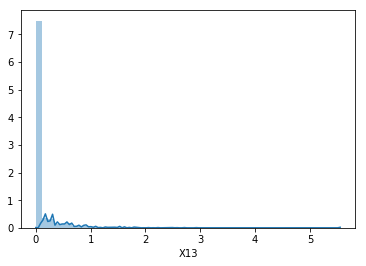

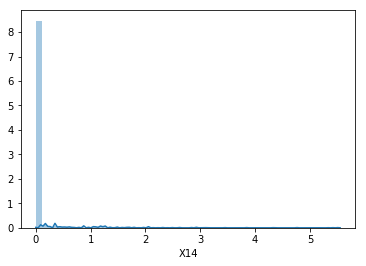

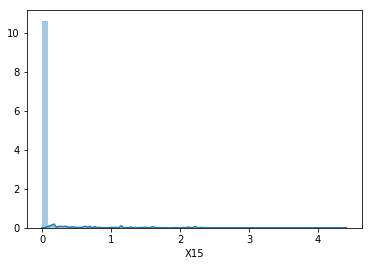

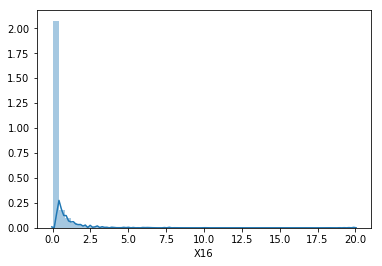

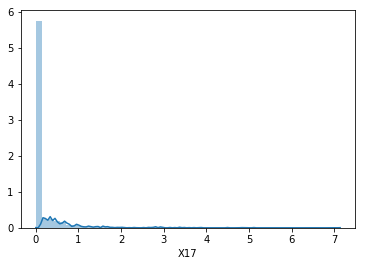

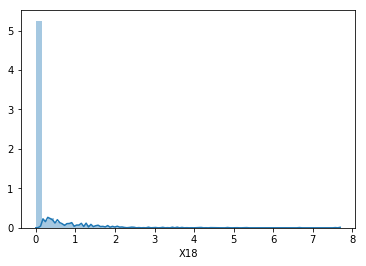

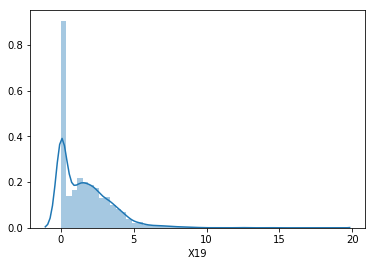

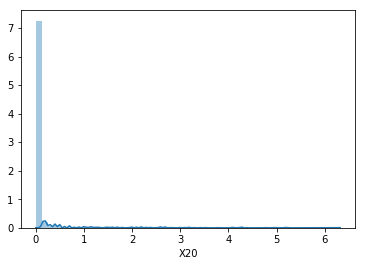

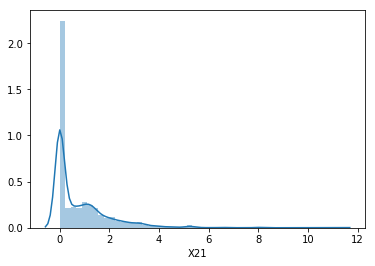

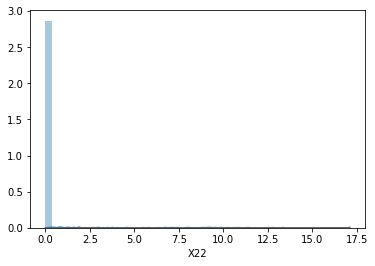

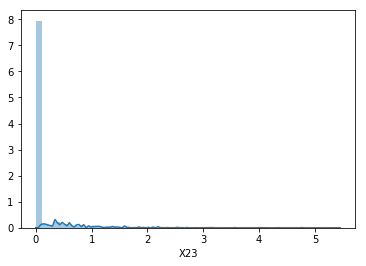

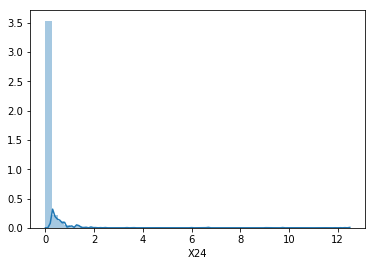

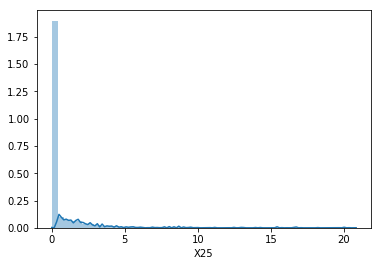

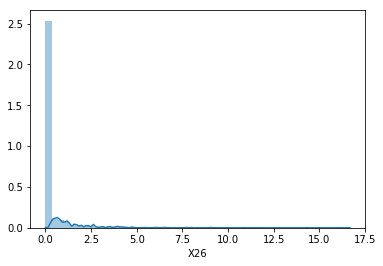

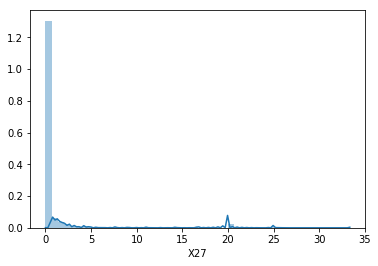

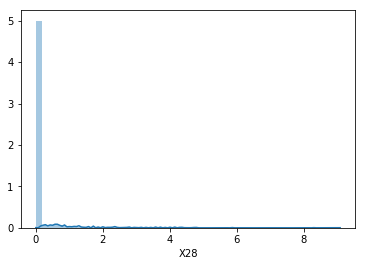

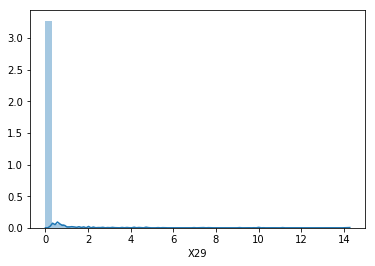

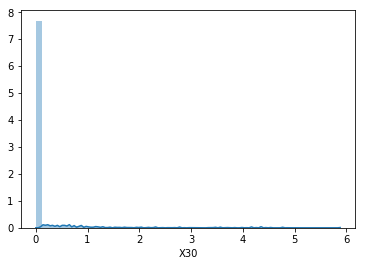

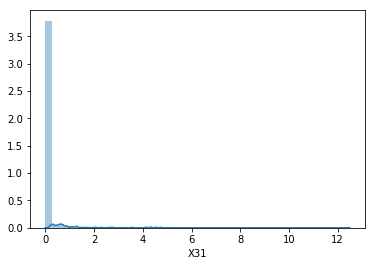

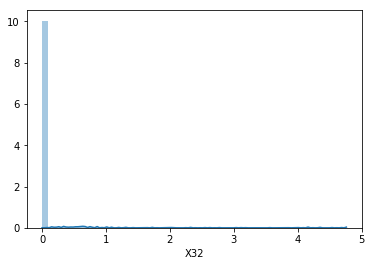

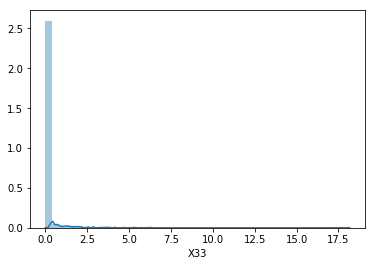

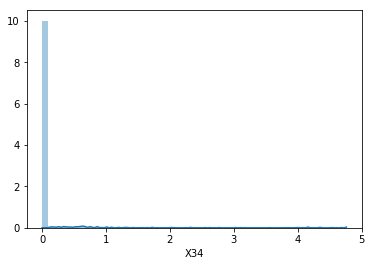

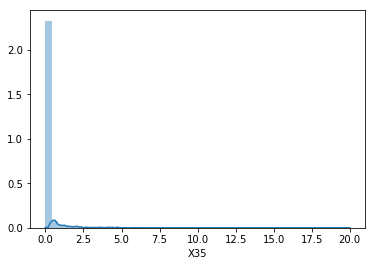

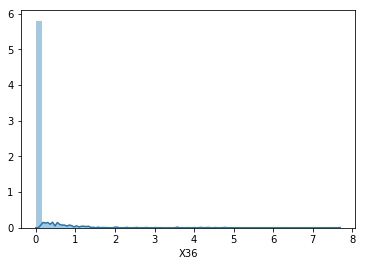

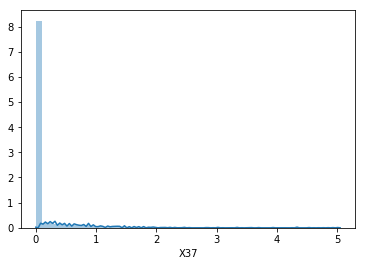

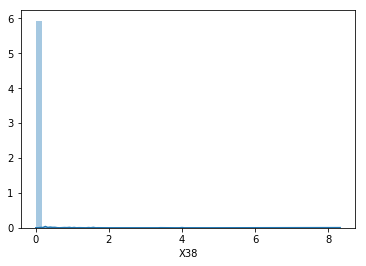

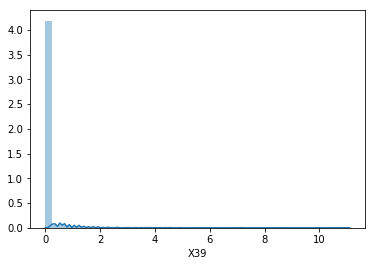

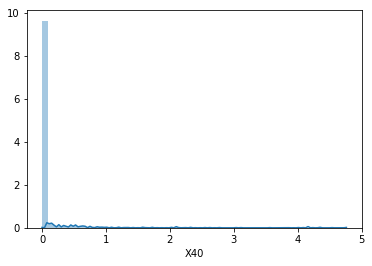

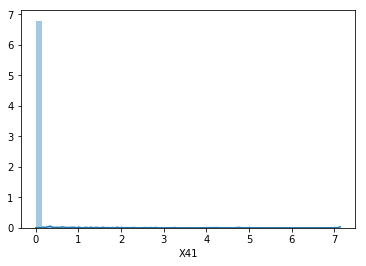

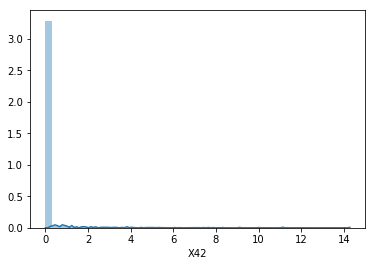

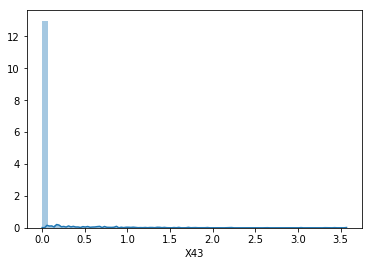

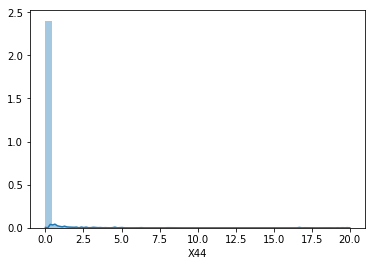

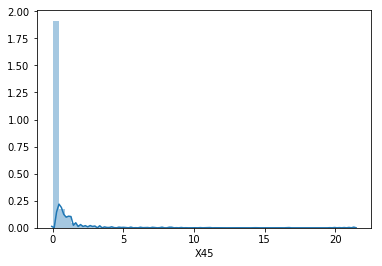

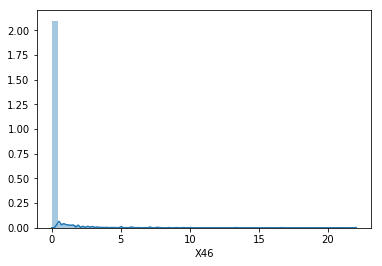

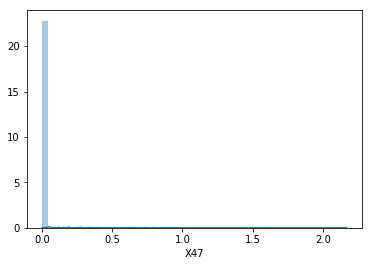

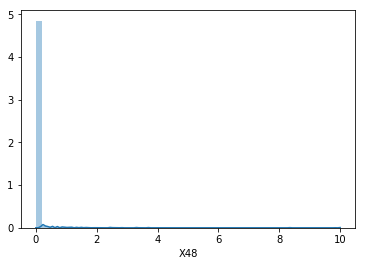

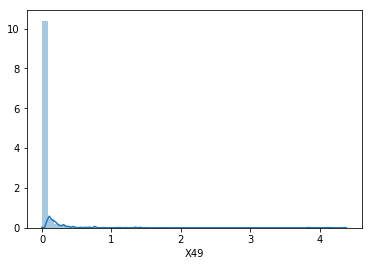

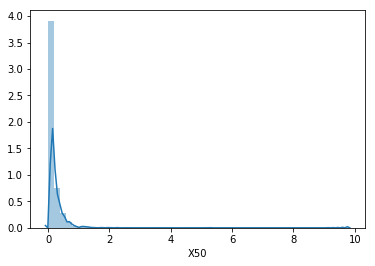

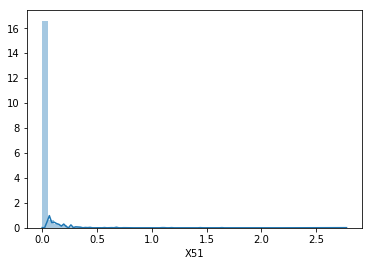

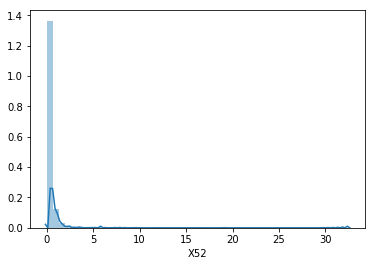

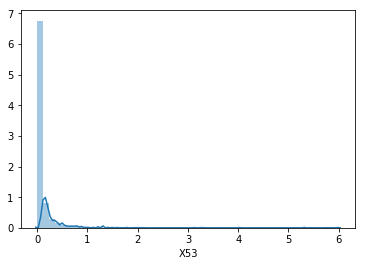

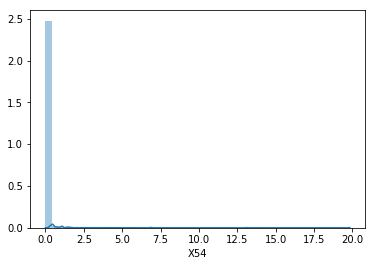

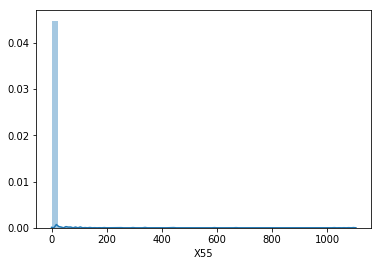

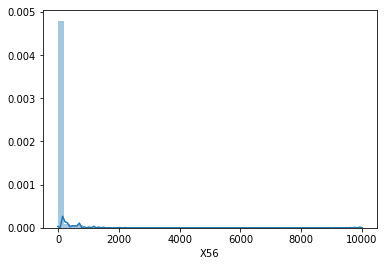

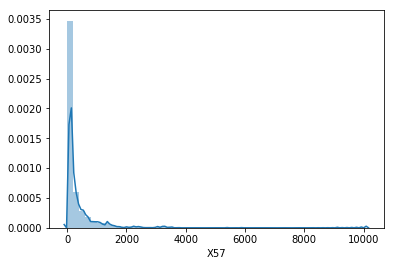

In [130]:
for c in poss_cont_cols: 
  sns.distplot(train_data[c])
  plt.show()

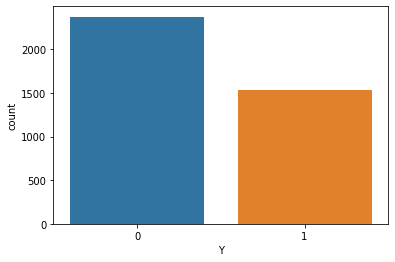

In [ ]:
for c in poss_cat_cols: 
  sns.countplot(train_data[c])
  plt.show()

#### Bivariate analysis

In [ ]:
# ?sns.boxplot

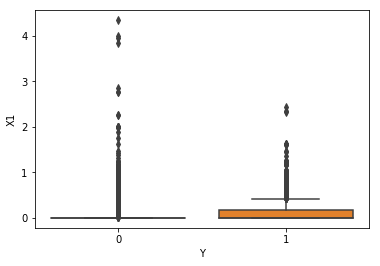

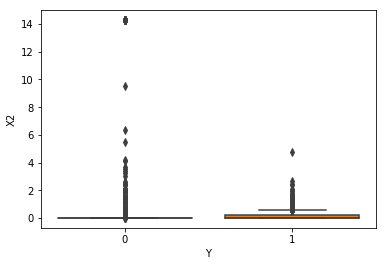

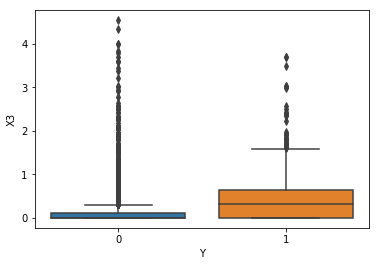

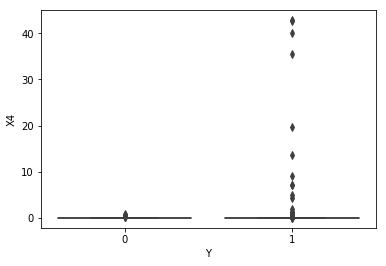

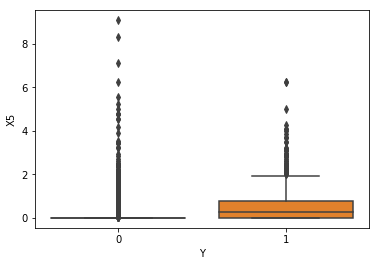

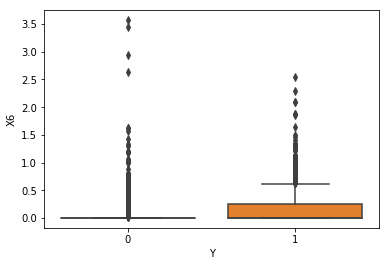

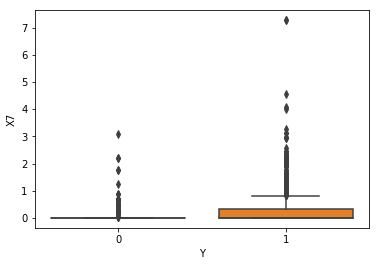

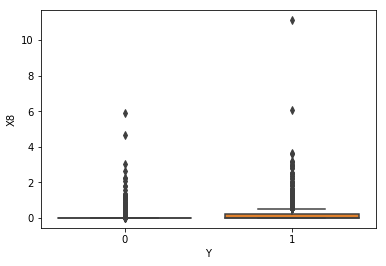

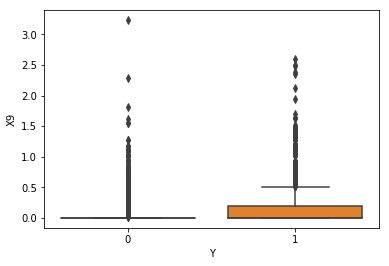

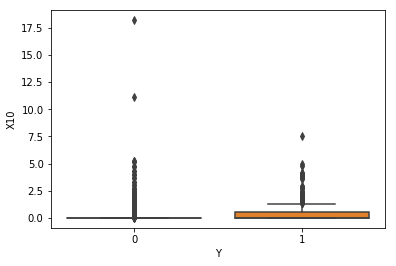

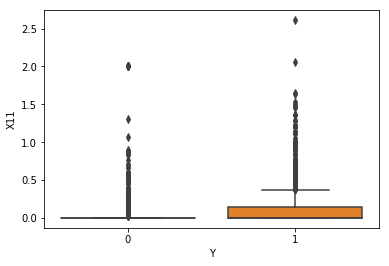

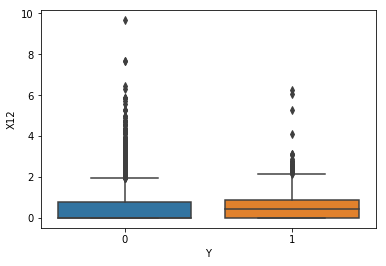

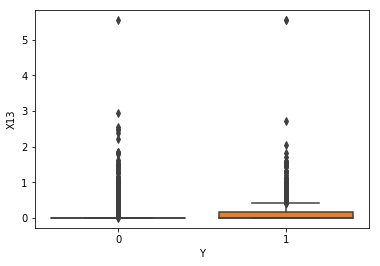

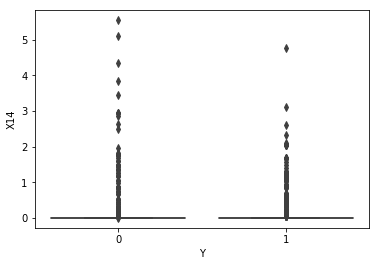

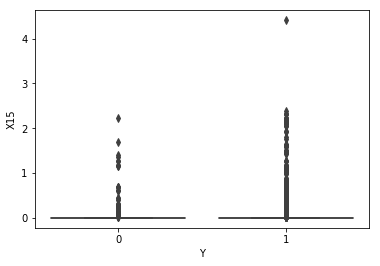

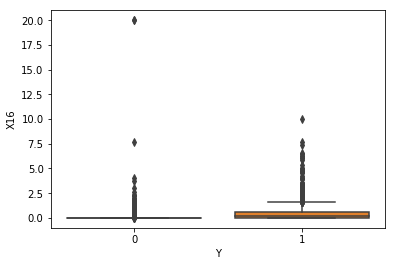

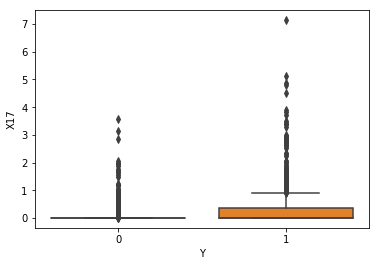

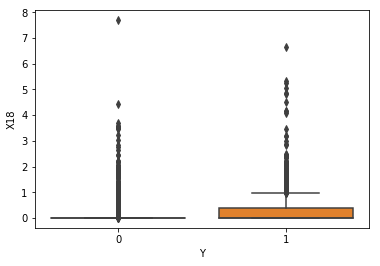

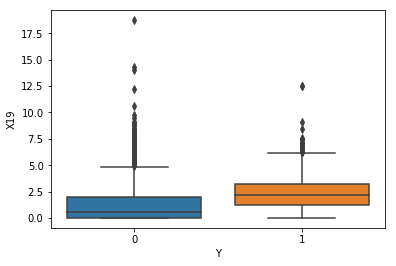

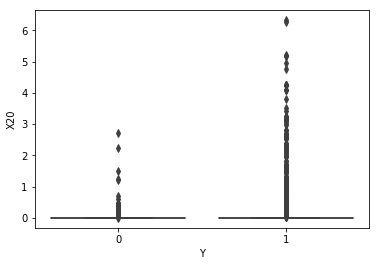

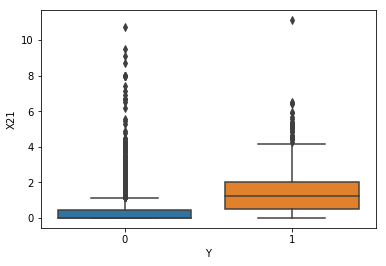

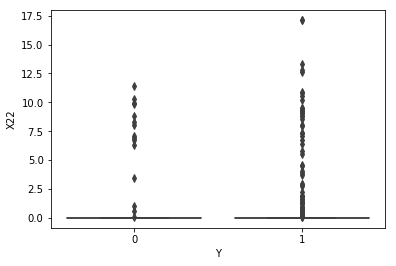

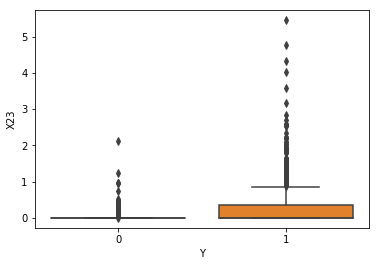

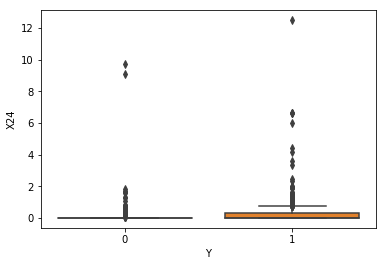

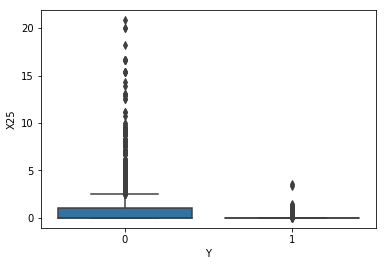

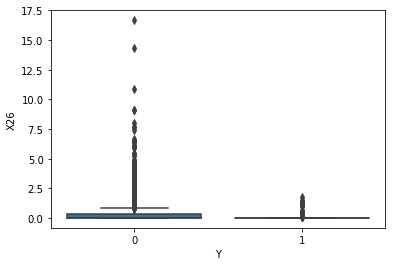

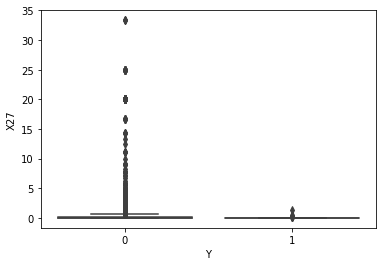

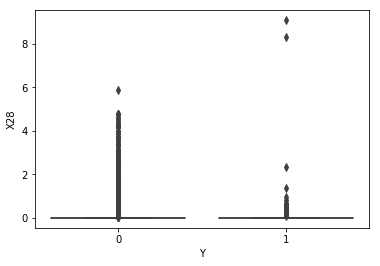

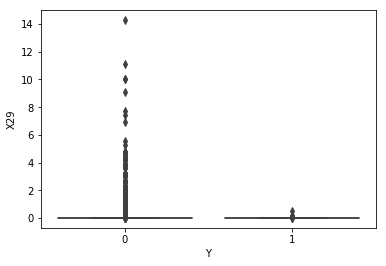

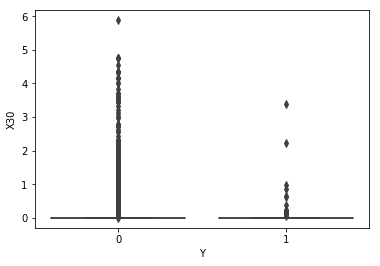

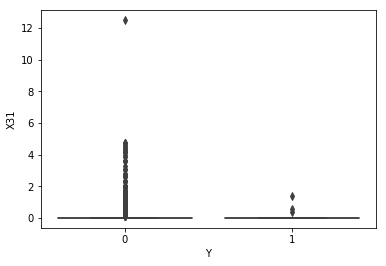

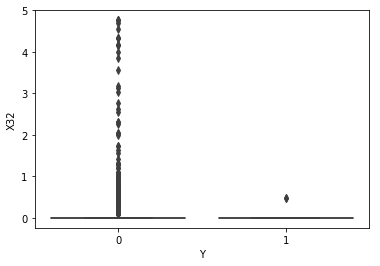

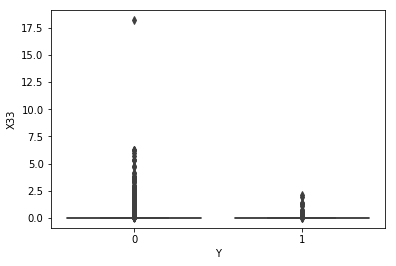

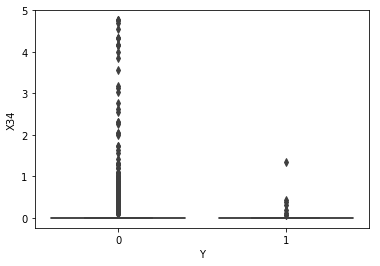

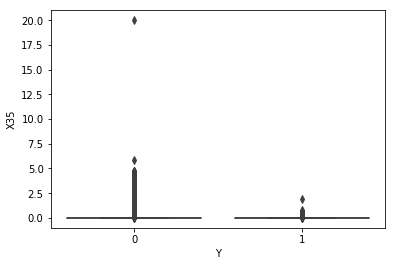

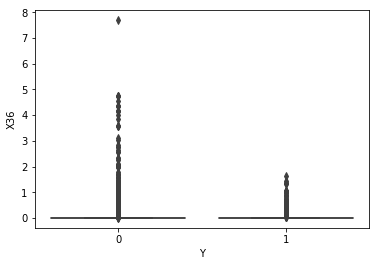

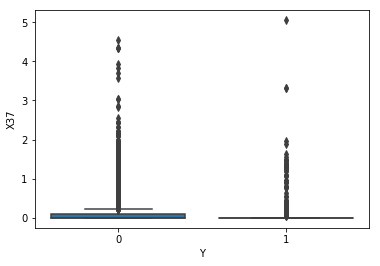

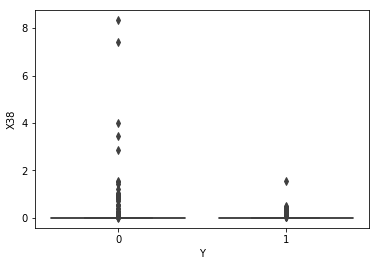

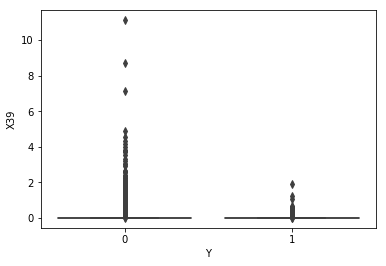

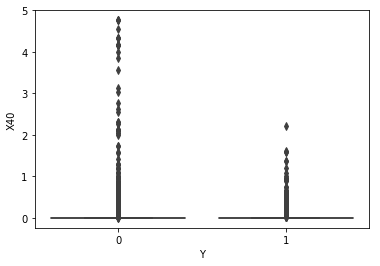

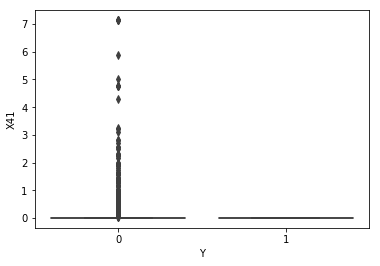

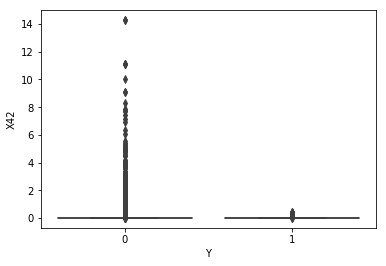

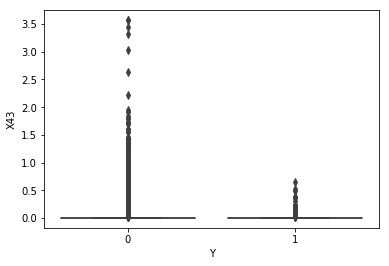

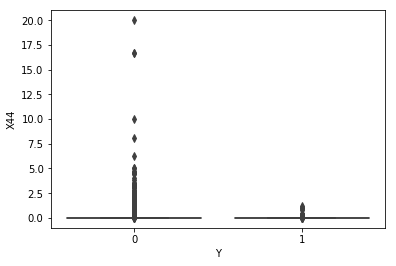

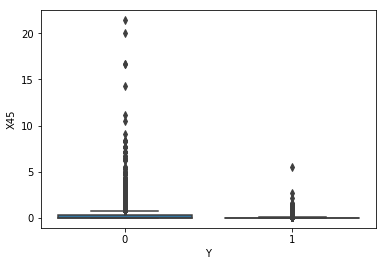

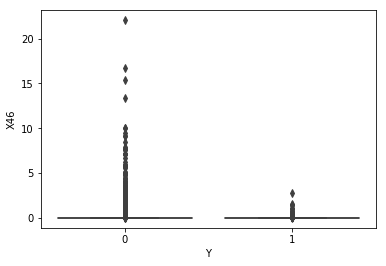

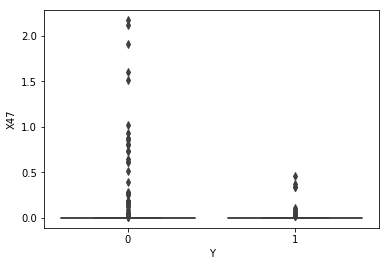

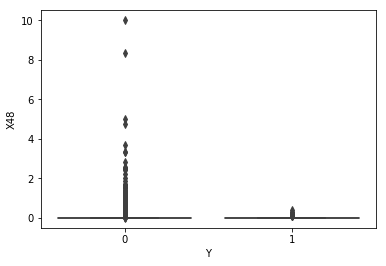

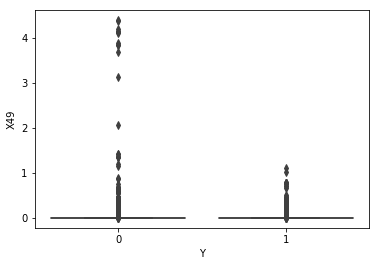

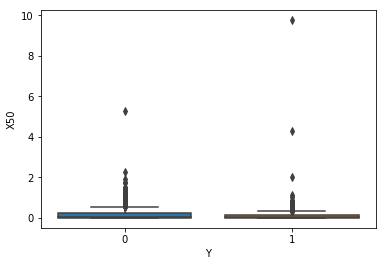

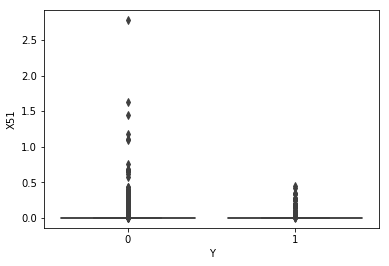

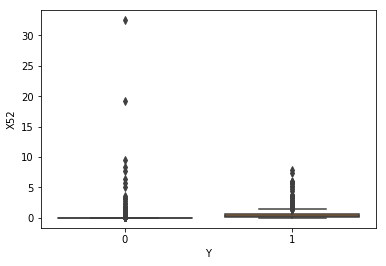

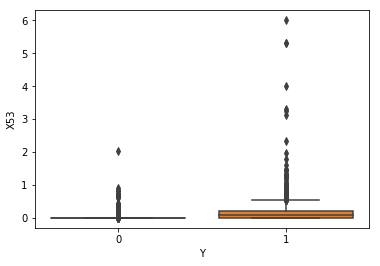

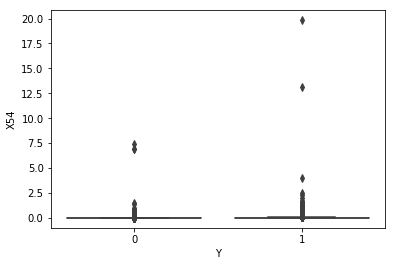

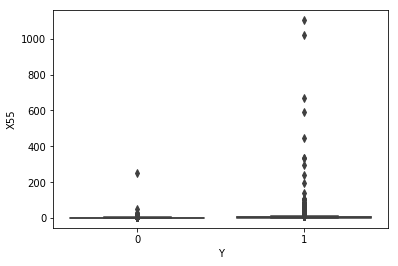

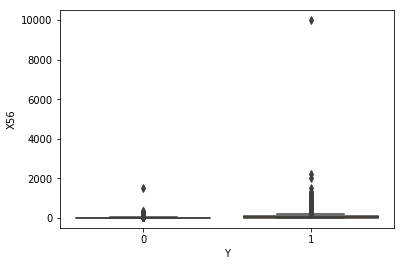

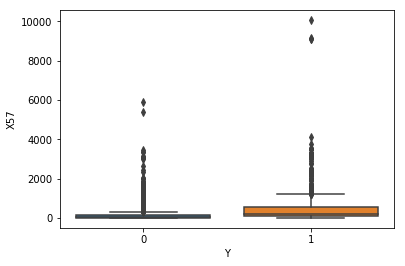

In [131]:
for c in poss_cont_cols: 
  sns.boxplot(y=c, x=target_variable, data=train_data)
  plt.show()

(893, 58)


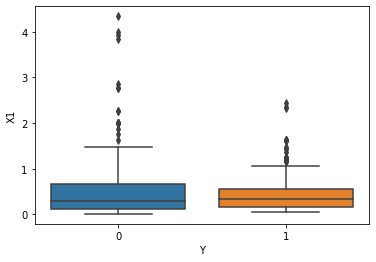

(764, 58)


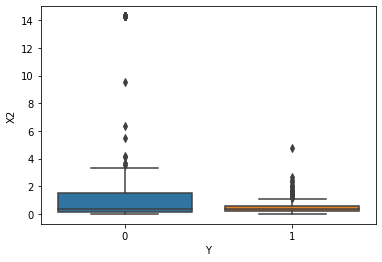

(1621, 58)


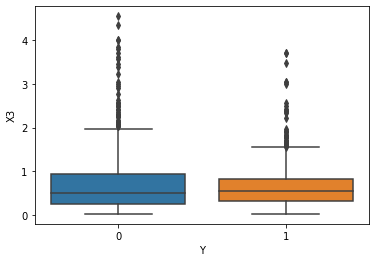

(39, 58)


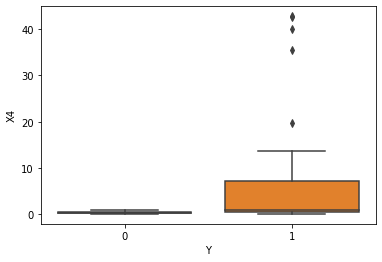

(1496, 58)


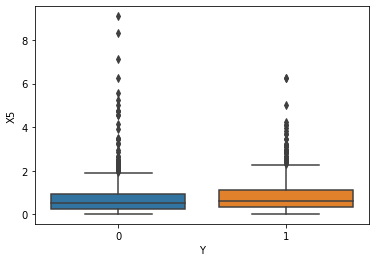

(860, 58)


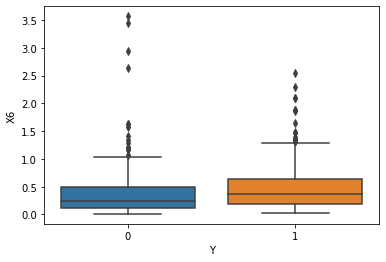

(684, 58)


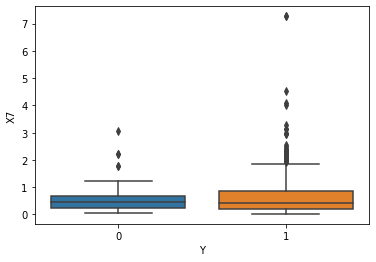

(715, 58)


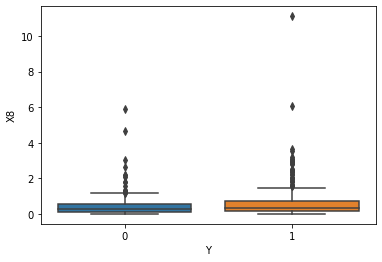

(663, 58)


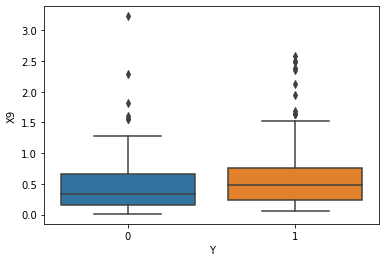

(1106, 58)


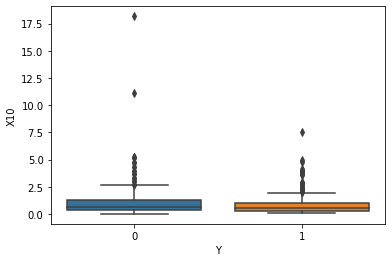

(608, 58)


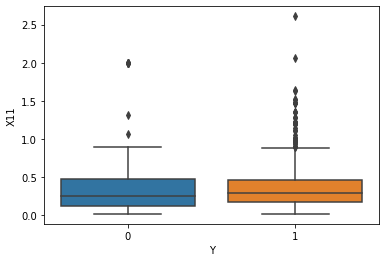

(1995, 58)


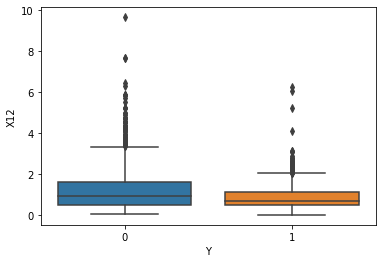

(727, 58)


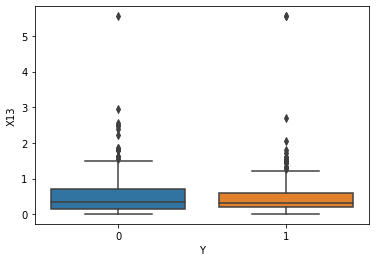

(307, 58)


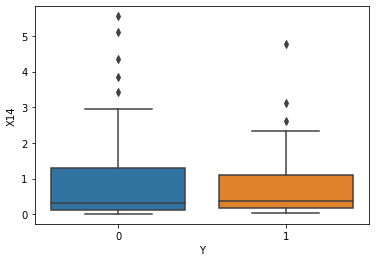

(282, 58)


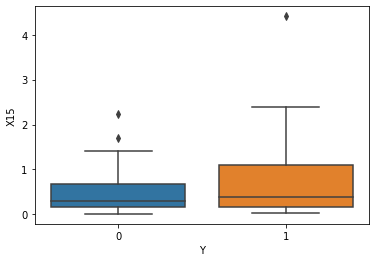

(1061, 58)


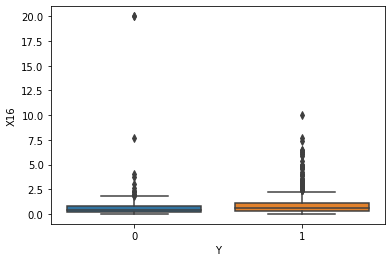

(824, 58)


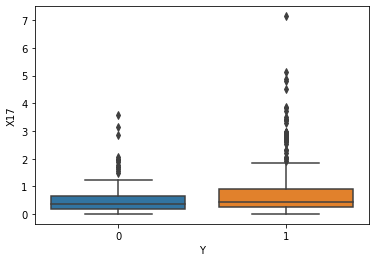

(884, 58)


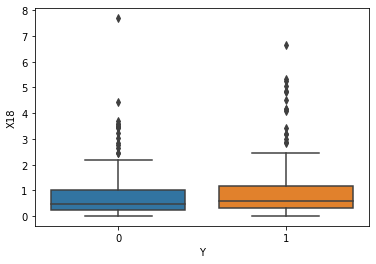

(2758, 58)


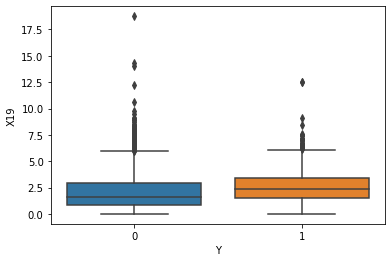

(364, 58)


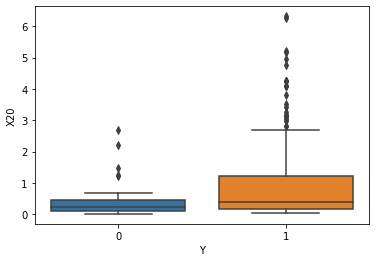

(2062, 58)


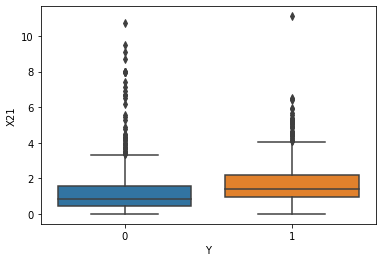

(89, 58)


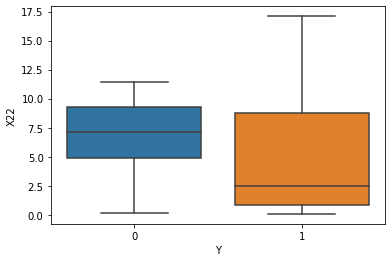

(580, 58)


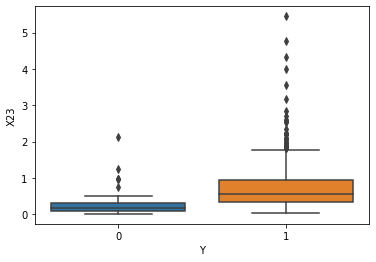

(630, 58)


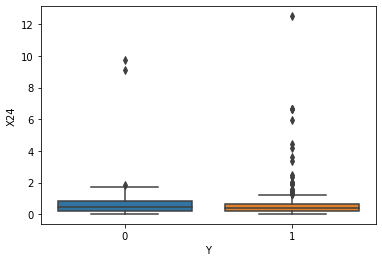

(932, 58)


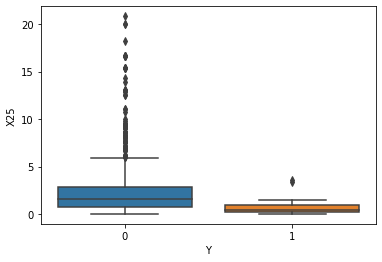

(692, 58)


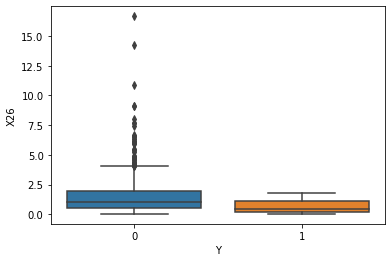

(672, 58)


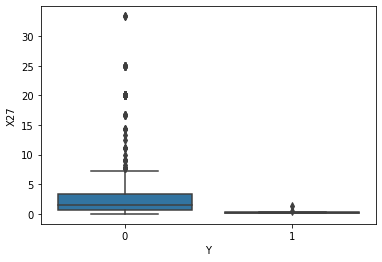

(390, 58)


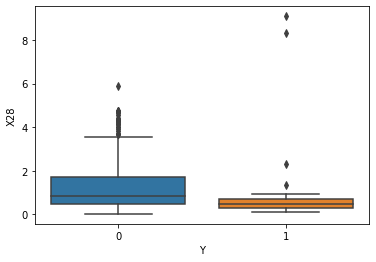

(315, 58)


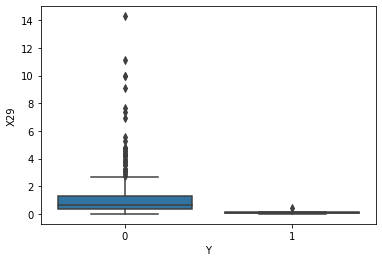

(399, 58)


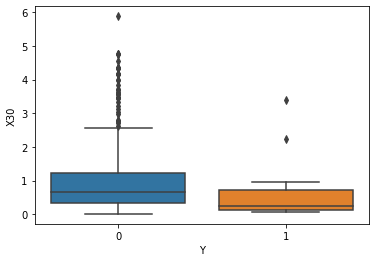

(249, 58)


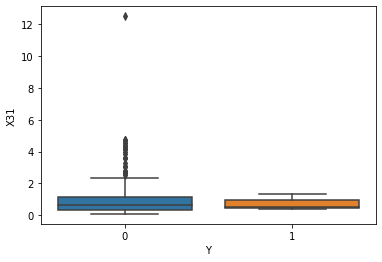

(176, 58)


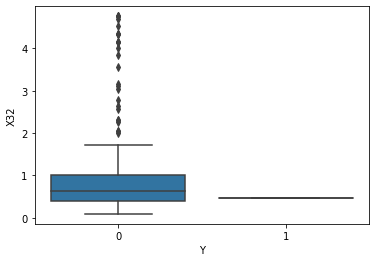

(345, 58)


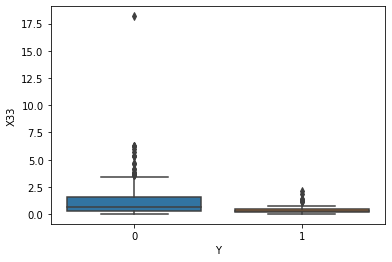

(184, 58)


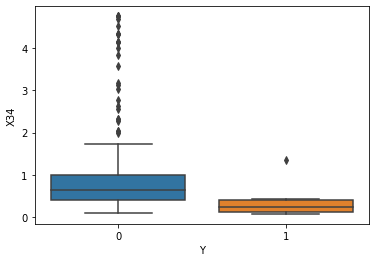

(414, 58)


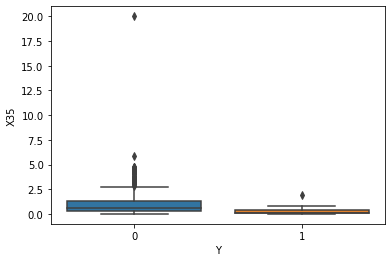

(498, 58)


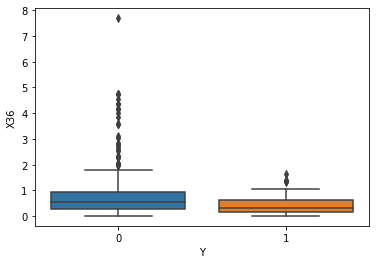

(700, 58)


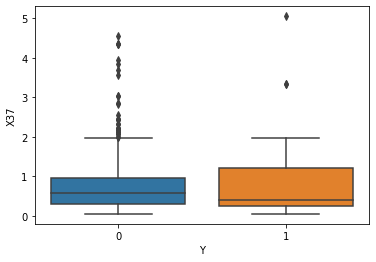

(74, 58)


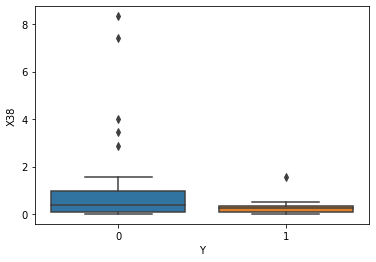

(336, 58)


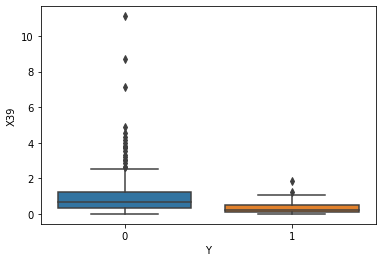

(387, 58)


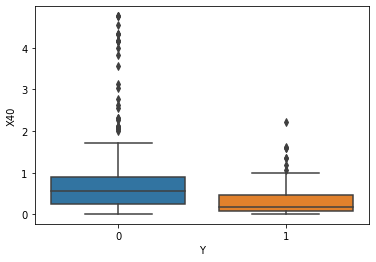

(126, 58)


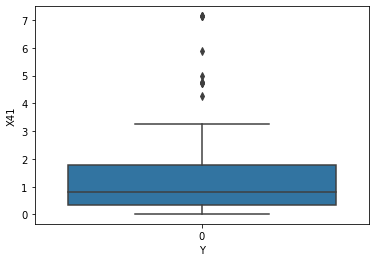

(291, 58)


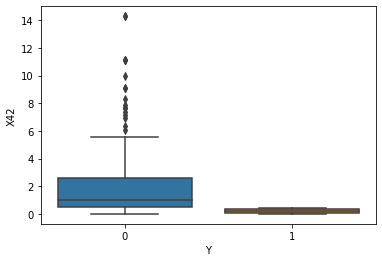

(319, 58)


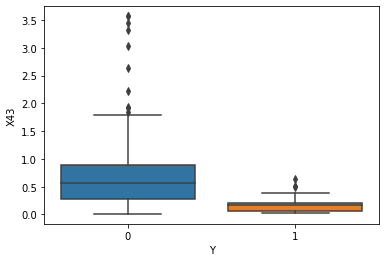

(284, 58)


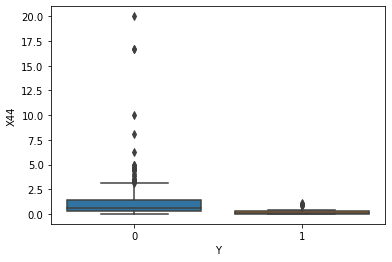

(1116, 58)


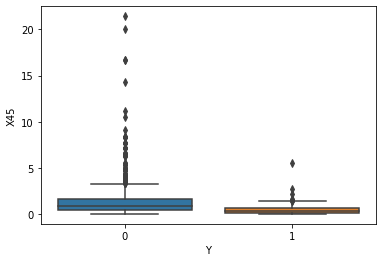

(427, 58)


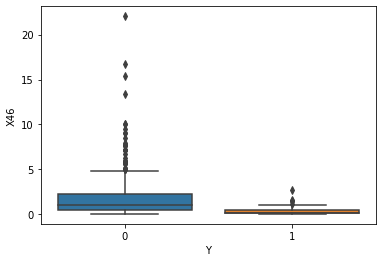

(56, 58)


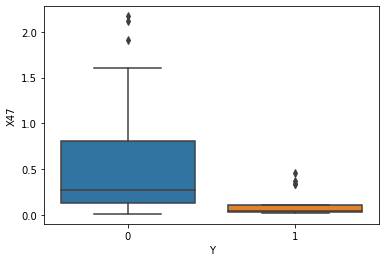

(172, 58)


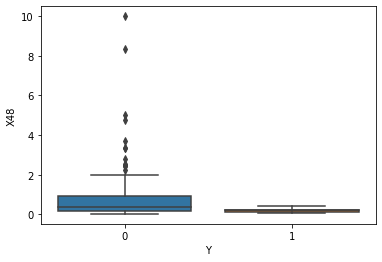

(671, 58)


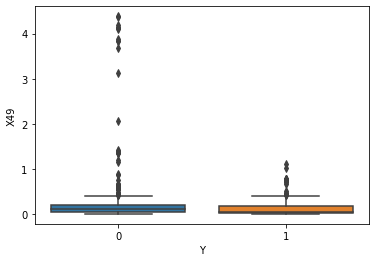

(2320, 58)


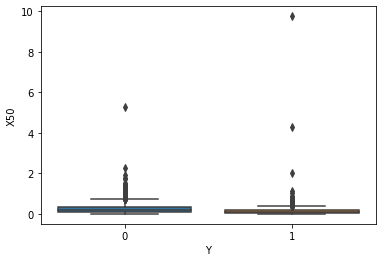

(457, 58)


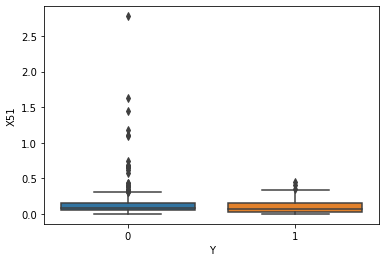

(1911, 58)


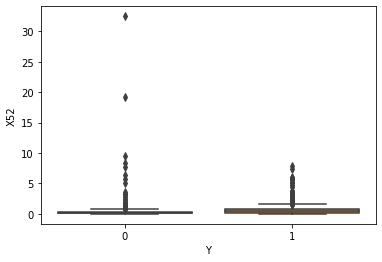

(1197, 58)


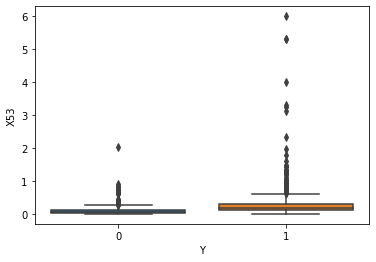

(643, 58)


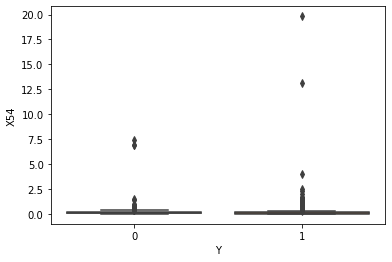

(3910, 58)


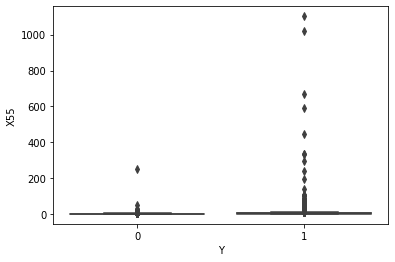

(3910, 58)


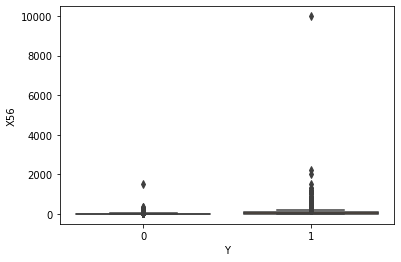

(3910, 58)


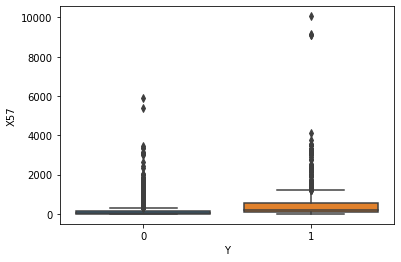

In [ ]:
for c in poss_cont_cols: 
  temp_df = train_data[train_data[c] !=0]
  sns.boxplot(y=c, x=target_variable, data=temp_df)
  print(temp_df.shape)
  plt.show()

In [ ]:
### on high level it is clear that few of the values are showing strong relation between when the target variable is 1 and 0

In [132]:
pd.concat([pd.DataFrame(train_data.groupby(target_variable).mean().T),
pd.DataFrame(train_data.groupby(target_variable).median().T)],axis=1)

Y,0,1,0,1
X1,0.072088,0.150854,0.0000,0.0000
X2,0.233089,0.165111,0.0000,0.0000
X3,0.201368,0.413057,0.0000,0.3100
X4,0.000896,0.156832,0.0000,0.0000
X5,0.183519,0.509244,0.0000,0.2900
X6,0.042702,0.178488,0.0000,0.0000
X7,0.009916,0.270932,0.0000,0.0000
X8,0.036427,0.213866,0.0000,0.0000
X9,0.035694,0.177034,0.0000,0.0000
X10,0.170257,0.359100,0.0000,0.0000


Y,0,1
X1,0.0000,0.0000
X2,0.0000,0.0000
X3,0.0000,0.3100
X4,0.0000,0.0000
X5,0.0000,0.2900
X6,0.0000,0.0000
X7,0.0000,0.0000
X8,0.0000,0.0000
X9,0.0000,0.0000
X10,0.0000,0.0000


In [94]:
# for c in poss_cont_cols : 
#   # temp_data = 
#   # sns.distplot(train_data[train_data[target_variable]==0][c])
#   sns.distplot(np.log1p(train_data[train_data[target_variable]==0][c]))

#   # sns.countplot(x=target_variable, hue=c, data=train_data)
#   plt.show()

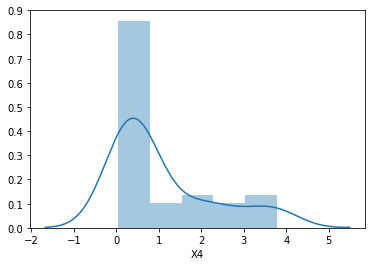

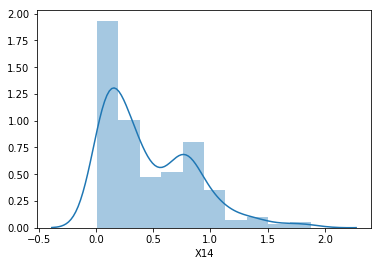

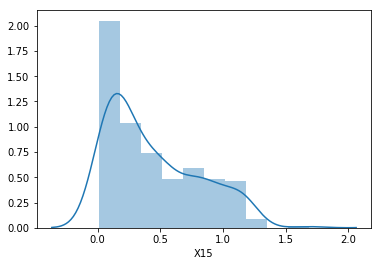

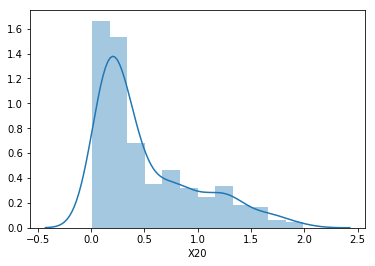

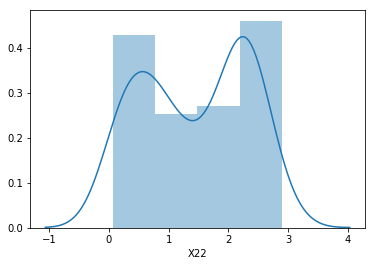

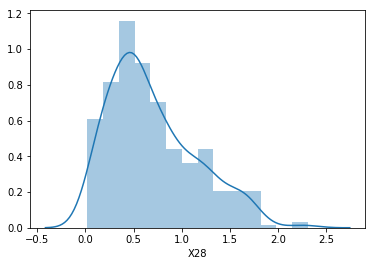

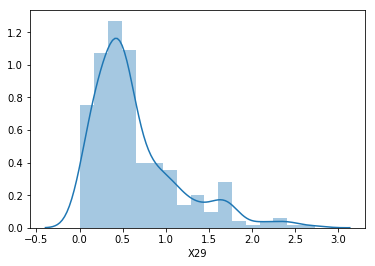

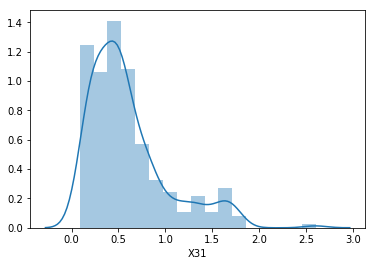

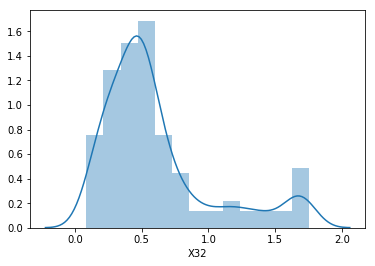

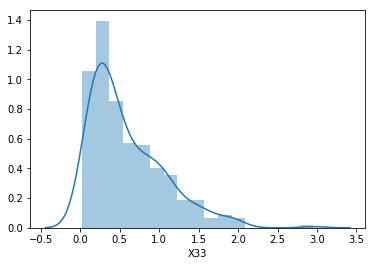

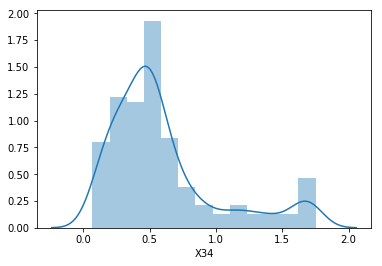

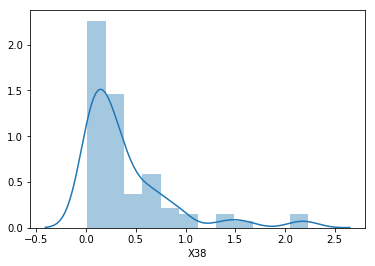

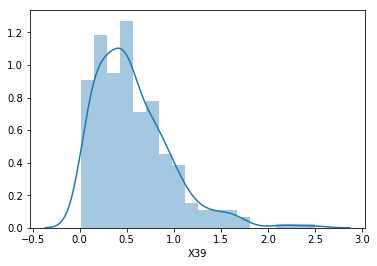

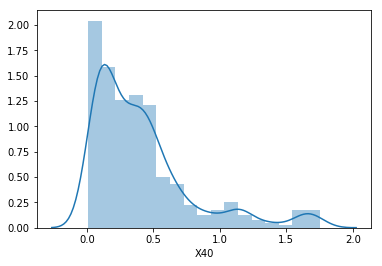

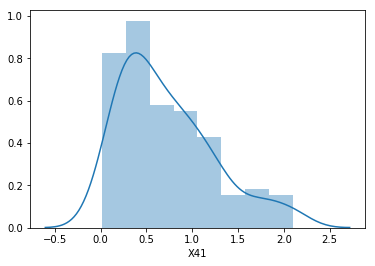

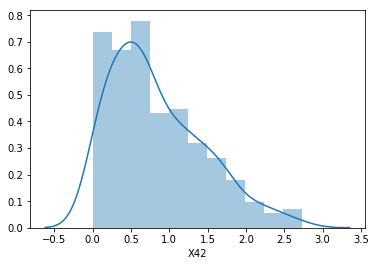

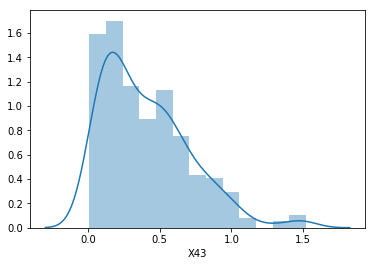

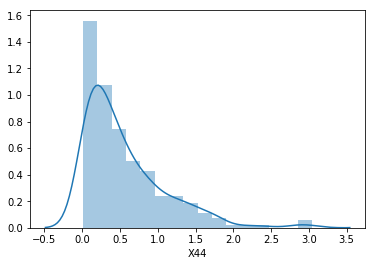

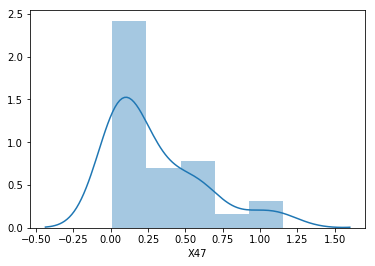

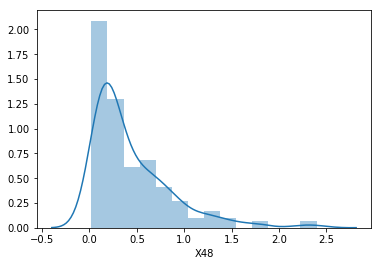

In [133]:
for col in cols_with_90_perc_zeros:
  temp_df = train_data[train_data[col] != 0]
  # sns.distplot(np.log1p(temp_df[col]))
  sns.distplot(np.log1p(temp_df[col]))
  plt.show()
  
# for c in poss_cont_cols : 
#   # temp_data = 
#   # sns.distplot(train_data[train_data[target_variable]==0][c])
#   sns.distplot(np.log1p(train_data[train_data[target_variable]==0][c]))

#   # sns.countplot(x=target_variable, hue=c, data=train_data)
#   plt.show()

In [ ]:
# sns.pairplot(df_for_analysis[poss_cont_cols[-2:]])
# plt.show()

In [ ]:
# sns.relplot(x=poss_cont_cols[-2], y=poss_cont_cols[-1], hue='satisfaction', data=df_for_analysis)
# plt.show()

In [ ]:
# poss_cat_cols

In [ ]:
# sns.relplot(x=poss_cat_cols[5], y=poss_cont_cols[-1], hue='satisfaction', data=data_filtered)
# plt.show()

# Cleaning and Feature Generation

Preparing different data sets for modelling

## From Train data - split data into test and train.

In [6]:
from sklearn.model_selection import train_test_split
target_variable = 'Y'
X_train, X_test, y_train, y_test = train_test_split(raw_data_dict['train'].drop(target_variable, axis=1), 
                                                    raw_data_dict['train'][target_variable],
                                                    stratify=raw_data_dict['train'][target_variable], 
                                                    test_size=0.2)
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)


In [7]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(confusion_matrix(y_test, lr.predict(X_test)))
print(classification_report(y_test, lr.predict(X_test)))

[[444  31]
 [ 31 276]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       475
           1       0.90      0.90      0.90       307

    accuracy                           0.92       782
   macro avg       0.92      0.92      0.92       782
weighted avg       0.92      0.92      0.92       782



In [9]:
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)
print(confusion_matrix(y_test, lr.predict(X_test_scaled)))
print(classification_report(y_test, lr.predict(X_test_scaled)))

[[446  29]
 [ 30 277]]
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       475
           1       0.91      0.90      0.90       307

    accuracy                           0.92       782
   macro avg       0.92      0.92      0.92       782
weighted avg       0.92      0.92      0.92       782



In [10]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(confusion_matrix(y_test, rf.predict(X_test)))
print(classification_report(y_test, rf.predict(X_test)))

[[457  18]
 [ 29 278]]
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       475
           1       0.94      0.91      0.92       307

    accuracy                           0.94       782
   macro avg       0.94      0.93      0.94       782
weighted avg       0.94      0.94      0.94       782



In [11]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [12]:
fi = rf_feat_importance(rf, X_train); imp_cols = fi[fi.imp > .005]['cols'].tolist()

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train[imp_cols], y_train)
print(confusion_matrix(y_test, rf.predict(X_test[imp_cols])))
print(classification_report(y_test, rf.predict(X_test[imp_cols])))

[[463  12]
 [ 23 284]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       475
           1       0.96      0.93      0.94       307

    accuracy                           0.96       782
   macro avg       0.96      0.95      0.95       782
weighted avg       0.96      0.96      0.96       782



In [ ]:
X_train['add_col'] = X_train.sum(axis=1)
X_test['add_col'] = X_test.sum(axis=1)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train[['add_col']], y_train)
print(classification_report(y_test, lr.predict(X_test[['add_col']])))

              precision    recall  f1-score   support

           0       0.67      0.92      0.77       475
           1       0.70      0.30      0.42       307

    accuracy                           0.67       782
   macro avg       0.68      0.61      0.60       782
weighted avg       0.68      0.67      0.63       782



In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train[['add_col']], y_train)
print(classification_report(y_test, rf.predict(X_test[['add_col']])))

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       475
           1       0.57      0.57      0.57       307

    accuracy                           0.66       782
   macro avg       0.65      0.65      0.65       782
weighted avg       0.66      0.66      0.66       782



In [ ]:
# from sklearn.decomposition import PCA, FastICA
# from sklearn.metrics import explained_variance_score
# for i in [ 5][::-1]:
#     pca = PCA(n_components=i)
#     pca.fit(X_train)
#     X_train_trf =pca.fit_transform(X_train)
#     X_train_inv = pca.inverse_transform(X_train_trf)
#     X_test_trf = pca.transform(X_test)
#     X_test_inv = pca.inverse_transform(X_test_trf)

#     print(i, explained_variance_score(X_train, X_train_inv, ),
#         explained_variance_score(X_test , X_test_inv ))

In [ ]:
# from sklearn.decomposition import PCA, FastICA
# from sklearn.metrics import explained_variance_score
# for i in [5, 15, 25, 30, 50][::-1]:
#     ica = FastICA(n_components=i)
#     ica.fit(X_train)
#     X_train_trf =ica.fit_transform(X_train)
#     X_train_inv = ica.inverse_transform(X_train_trf)
#     X_test_trf = ica.transform(X_test)
#     X_test_inv = ica.inverse_transform(X_test_trf)

#     print(i, explained_variance_score(X_train, X_train_inv, ),
#         explained_variance_score(X_test , X_test_inv ))

## Modelling

List of Machine Learning algorithms which are not sensitive to outliers:
```
1- Decision Tree
2- Random Forest
3- XGBoost
4- AdaBoost
5- Naive Bayes
6- If possible use NN (code written by me) it is available at github as well. share the link (https://github.com/Jagatbhat09/Deep_Learning/tree/master/NN_from_scratch) 


List of Machine Learning algorithms which are sensitive to outliers:
1- Linear Regression
2- Logistic Regression
3- Support Vector Machine
4- K- Nearest Neighbors
5- K-Means Clustering
6- Hierarchical Clustering
7- Principal Component Analysis
```

Different experiments to try out

1. Base model -- with no tuning. just the filled data
2. with features a
3. with features b
4. with features c


also set up AUC for evaluating different models. 
Storing the results for each of the models make it very important. 



In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

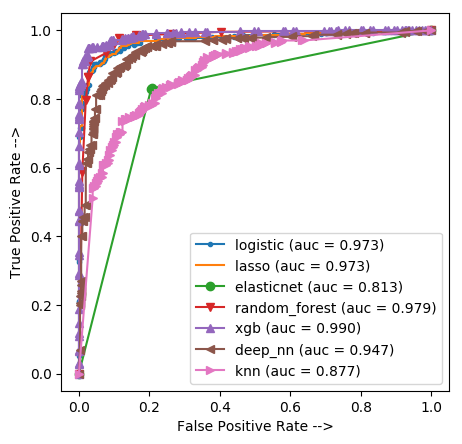

In [14]:
estimators=[
    # ('ridge',RidgeClassifier()),
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    ('deep_nn',MLPClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]

def run_modeling(X_train, y_train, X_test, y_test, estimators=estimators): 
    model_output_dict = {}
    model_output_dict_test = {}

    for model in estimators:
        # pipe=Pipeline(steps=[('data_prep', feature_genearation),model])
        model[1].fit(X_train, y_train)

        model_output_dict[model[0]] = {
            'y' : y_train.astype(int),
            'y_pred': model[1].predict_proba(X_train)[:,0],
        }

        model_output_dict_test[model[0]] = {
            'y' : y_test.astype(int),
            'y_pred': model[1].predict_proba(X_test)[:,0],
        }
        
    plot_auc_plots(model_output_dict_test, pos_label=0)
    return model_output_dict, model_output_dict_test


_ = run_modeling(X_train, y_train, X_test,
                 y_test, estimators=estimators)


# features_key = 'basic_features_scaled_1'
# model_input_dict = model_data_dict[features_key]
# estimators=[
#     ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
#     ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
# ]

# _ = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
#                  model_input_dict['y_test'], estimators=estimators)

In [15]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
_metrics = {'auc':make_scorer(roc_auc_score)}

param_grid= {
 'n_estimators':[10,50,100,150,200, 300, 500, 800],
 'max_depth':[3,5,8,10,13,15,18],
'max_leaf_nodes':[3, 5,7, 10,15,20,25]   
}
rfc = RandomForestClassifier() 
rfc_gs=GridSearchCV(rfc, param_grid,scoring=_metrics,refit='auc',cv=5, verbose=2,
                    n_jobs=-1)
rfc_params = rfc_gs.fit(X_train, y_train)


Fitting 5 folds for each of 392 candidates, totalling 1960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 584 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 949 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 1394 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 1960 out of 1960 | elapsed:   35.2s finished


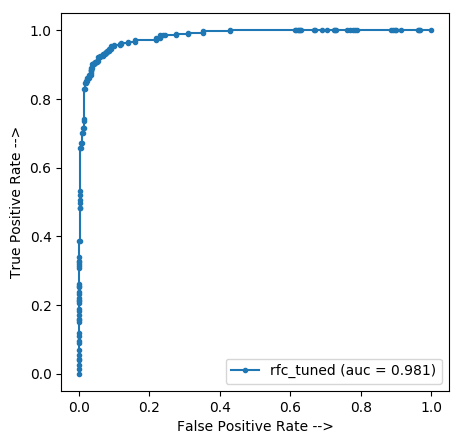

In [17]:
rfc_best = RandomForestClassifier(**rfc_params.best_params_) 
rfc_best.fit(X_train, y_train)
y_preds = rfc_best.predict_proba(X_test)
plot_auc_plots({'rfc_tuned': { 'y': y_test, 'y_pred': y_preds[:,1]}})

In [85]:
print(confusion_matrix(y_test, rfc_best.predict(X_test)))

[[457  18]
 [ 33 274]]


Fitting 5 folds for each of 392 candidates, totalling 1960 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=16)]: Done 130 tasks      | elapsed:    7.9s
[Parallel(n_jobs=16)]: Done 333 tasks      | elapsed:   22.2s
[Parallel(n_jobs=16)]: Done 616 tasks      | elapsed:   52.3s
[Parallel(n_jobs=16)]: Done 981 tasks      | elapsed:  1.8min
[Parallel(n_jobs=16)]: Done 1426 tasks      | elapsed:  3.0min
[Parallel(n_jobs=16)]: Done 1960 out of 1960 | elapsed:  4.6min finished


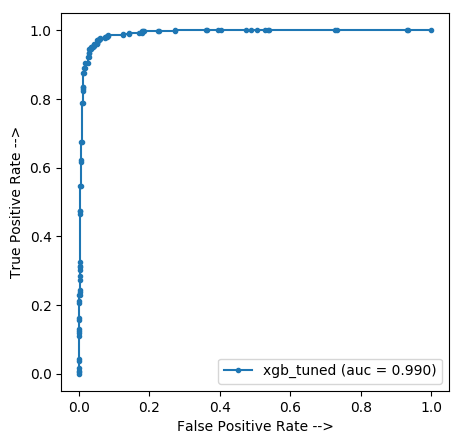

In [197]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
_metrics = {'auc':make_scorer(roc_auc_score)}
## the model optimises on auc
parameters = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBClassifier() 
xgb_gs=GridSearchCV(xgb, param_grid,scoring=_metrics,refit='auc',cv=5, verbose=2,
                    n_jobs=16)
xgb_params = xgb_gs.fit(X_train, y_train)


xgb = XGBClassifier(**xgb_params.best_params_)
xgb.fit(X_train, y_train)
y_preds = xgb.predict_proba(X_test)
plot_auc_plots({'xgb_tuned': { 'y': y_test, 'y_pred': y_preds[:,1]}})




In [76]:
print(classification_report(y_test, xgb.predict(X_test)) )

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       475
           1       0.95      0.94      0.95       307

    accuracy                           0.96       782
   macro avg       0.96      0.96      0.96       782
weighted avg       0.96      0.96      0.96       782



In [91]:
# fpr, tpr, threshold = roc_curve(y_test,
#                                     y_preds[:,1],
#                                     pos_label=1)
# sorted(list(zip(fpr, tpr, threshold)), key=lambda x: x[1], reverse=True)

<!-- Ideally we want to choose a cutoff/threshold which has higher TPR and low FPR

In this case we can go with  (0.08210526315789474, 0.9869706840390879, 0.042434644),
and hence the cutoff is 0.04 -->

In [39]:
# y_preds_out = np.where(y_preds[:,1] < 0.042434644, 0, 1)

In [ ]:
# theshold = 0.042434644
print(confusion_matrix(y_test, r.predict(X_test)))

[[457  18]
 [ 33 274]]


In [83]:
# theshold = 0.042434644
print(confusion_matrix(y_test, xgb.predict(X_test)))

[[459  16]
 [ 17 290]]


In [82]:
print(confusion_matrix(y_test, y_preds_out))

[[436  39]
 [  4 303]]


In [93]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       475
           1       0.95      0.94      0.95       307

    accuracy                           0.96       782
   macro avg       0.96      0.96      0.96       782
weighted avg       0.96      0.96      0.96       782



In [59]:
from sklearn.tree import export_graphviz
import IPython, graphviz, sklearn, warnings
import re
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

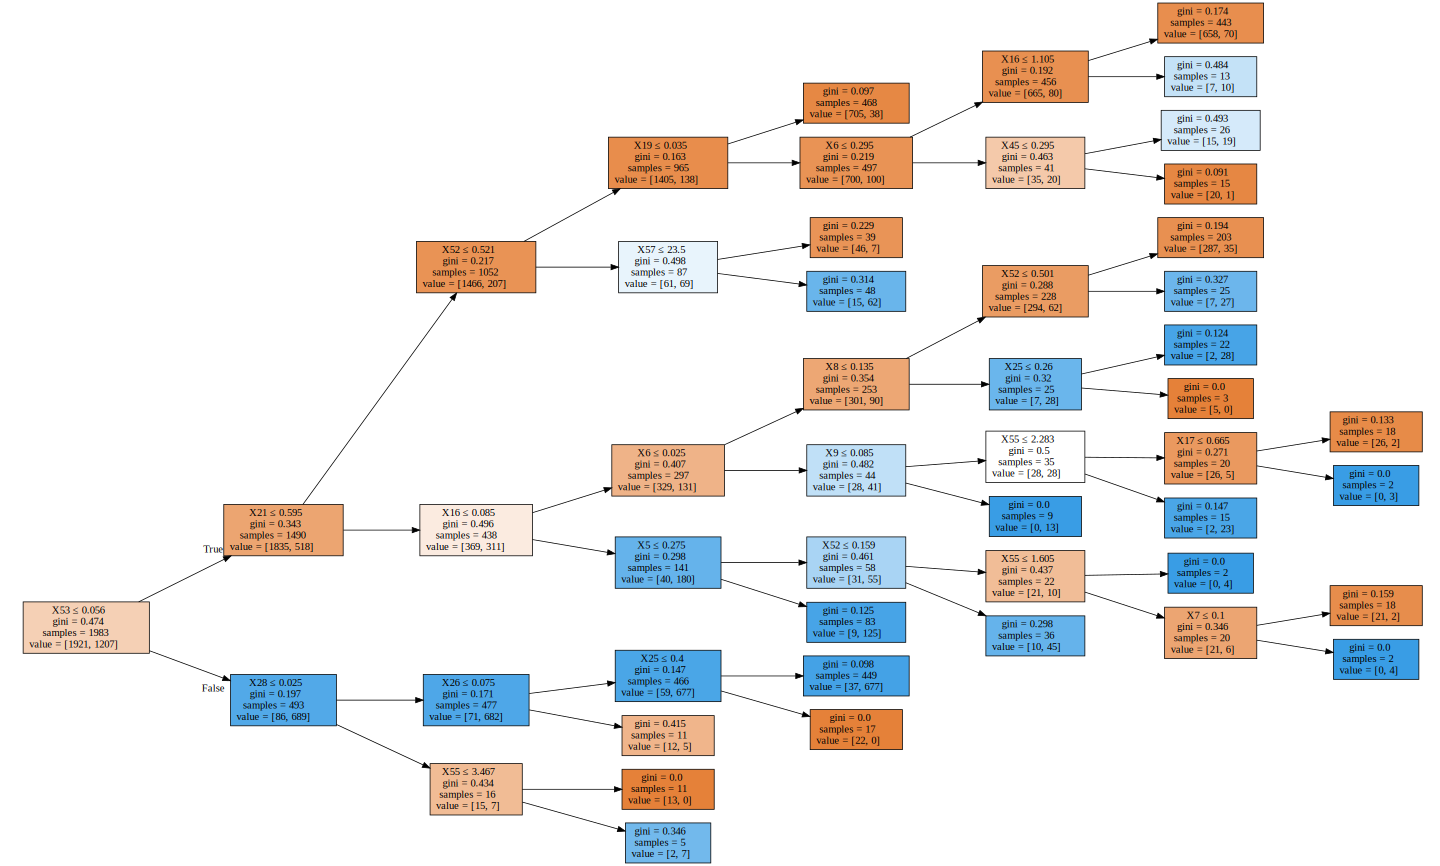

In [60]:
draw_tree(rfc_best.estimators_[0], X_train, precision=3, size=20)

This helps us to understand how the Tree was split on what conditions. 
Each of the features are contributing to the target variables even though they are skewed.
As for most of the feature it explain, as we had seen most of the cases outlier seen in either of the target class.
Was showing strong relation between them. 

In [65]:
# raw_data_dict['test']

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57
0,0.70,0.00,0.70,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.000,0.000,0.105,0.000,0.000,2.342,47,89
1,0.00,0.00,0.84,0.0,0.84,0.00,0.84,0.00,0.00,0.00,...,0.00,0.000,0.388,0.000,0.776,0.129,0.000,10.375,168,249
2,0.46,0.30,0.46,0.0,0.05,0.12,0.05,0.28,0.43,0.74,...,0.00,0.000,0.065,0.000,0.325,0.756,0.153,5.891,193,3040
3,0.10,0.20,1.01,0.0,0.80,0.80,0.50,0.00,0.80,0.10,...,0.00,0.000,0.110,0.000,0.490,0.158,0.015,8.550,669,1351
4,0.00,0.00,0.72,0.0,0.72,0.00,0.72,0.00,0.00,0.00,...,0.00,0.000,0.364,0.000,0.729,0.121,0.000,7.781,32,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,...,0.00,0.301,0.473,0.043,0.043,0.000,0.000,2.111,17,190
687,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,2.56,0.000,0.000,0.000,0.375,0.000,0.000,2.250,7,36
688,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.000,0.000,0.000,0.000,0.000,2.333,5,7
689,0.08,0.08,0.57,0.0,0.48,0.00,0.00,0.08,0.00,0.00,...,0.08,0.011,0.034,0.000,0.057,0.022,0.000,1.875,65,542


In [90]:
y_test_out = xgb.predict(raw_data_dict['test'])
submission_df = pd.DataFrame(y_test_out, columns=['Y'])
submission_df.to_csv('submission.csv')

In [74]:
pip freeze > req.txt

Note: you may need to restart the kernel to use updated packages.


In [151]:
cols_with_lots_zeros

Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21',
       'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31',
       'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41',
       'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51',
       'X52', 'X53', 'X54', 'Y'],
      dtype='object')

In [179]:
X_train_copy = X_train.copy()
cols = []
for c in cols_with_lots_zeros[:-1]:
    X_train_copy[c+ '_isnonzero'] =  np.where(X_train_copy[c] == 0 , 0, 1)
    cols.append(c+ '_isnonzero')

X_test_copy = X_test.copy()
for c in cols_with_lots_zeros[:-1]:
    X_test_copy[c+ '_isnonzero'] =  np.where(X_test_copy[c] == 0 , 0, 1)
    # cols.append(c+ '_isnonzero')

In [186]:
cols_with_no_zeros

Index(['X55', 'X56', 'X57'], dtype='object')

In [189]:
all_cols = cols + list(cols_with_no_zeros)

In [190]:
# X_train_copy[ all_cols]

In [191]:
xgb_2 = XGBClassifier() 
xgb_2.fit(X_train_copy[all_cols], y_train) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [192]:
print(classification_report(y_test, xgb_2.predict(X_test_copy[all_cols])))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       475
           1       0.93      0.93      0.93       307

    accuracy                           0.95       782
   macro avg       0.94      0.94      0.94       782
weighted avg       0.94      0.95      0.94       782



In [145]:
# dict(X_train_copy.describe())

Fitting 5 folds for each of 392 candidates, totalling 1960 fits


[Parallel(n_jobs=28)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=28)]: Done 456 tasks      | elapsed:    6.2s
[Parallel(n_jobs=28)]: Done 979 tasks      | elapsed:   13.0s
[Parallel(n_jobs=28)]: Done 1269 tasks      | elapsed:   16.9s
[Parallel(n_jobs=28)]: Done 1634 tasks      | elapsed:   22.2s
[Parallel(n_jobs=28)]: Done 1960 out of 1960 | elapsed:   27.6s finished


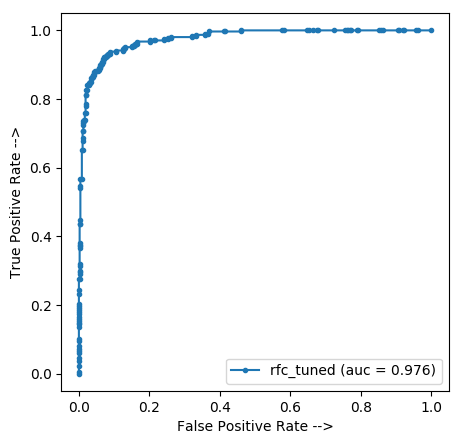

In [198]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
_metrics = {'auc':make_scorer(roc_auc_score)}

param_grid= {
 'n_estimators':[10,50,100,150,200, 300, 500, 800],
 'max_depth':[3,5,8,10,13,15,18],
'max_leaf_nodes':[3, 5,7, 10,15,20,25]   
}
rfc = RandomForestClassifier() 
rfc_gs=GridSearchCV(rfc, param_grid,scoring=_metrics,refit='auc',cv=5, verbose=2,
                    n_jobs=28)
rfc_params = rfc_gs.fit(X_train_copy[all_cols], y_train)

rfc_best = RandomForestClassifier(**rfc_params.best_params_) 
rfc_best.fit(X_train_copy[all_cols], y_train)
y_preds = rfc_best.predict_proba(X_test_copy[all_cols])
plot_auc_plots({'rfc_tuned': { 'y': y_test, 'y_pred': y_preds[:,1]}})

Fitting 5 folds for each of 392 candidates, totalling 1960 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 267 tasks      | elapsed:   14.8s
[Parallel(n_jobs=16)]: Done 476 tasks      | elapsed:   31.9s
[Parallel(n_jobs=16)]: Done 759 tasks      | elapsed:  1.1min
[Parallel(n_jobs=16)]: Done 1124 tasks      | elapsed:  2.0min
[Parallel(n_jobs=16)]: Done 1569 tasks      | elapsed:  3.2min
[Parallel(n_jobs=16)]: Done 1960 out of 1960 | elapsed:  4.3min finished


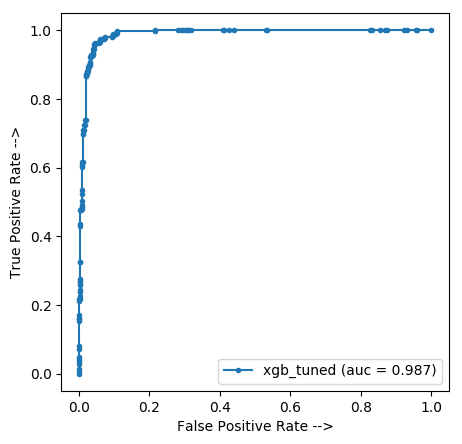

In [200]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
_metrics = {'auc':make_scorer(roc_auc_score)}
## the model optimises on auc
parameters = {
    'max_depth': [3, 5, 7, 9], 
    'n_estimators': [5, 10, 15, 20, 25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}

xgb = XGBClassifier() 
xgb_gs=GridSearchCV(xgb, param_grid,scoring=_metrics,refit='auc',cv=5, verbose=2,
                    n_jobs=16)
xgb_params = xgb_gs.fit(X_train_copy[all_cols], y_train)


xgb = XGBClassifier(**xgb_params.best_params_)
xgb.fit(X_train_copy[all_cols], y_train)
y_preds = xgb.predict_proba(X_test_copy[all_cols])
plot_auc_plots({'xgb_tuned': { 'y': y_test, 'y_pred': y_preds[:,1]}})


